# Data mining project 22/23

## Import libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "10" # to avoid possible memory leak with KMeans

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# zscore
from scipy.stats import zscore
# kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

## Theory

To understand first each variable, let's review some audio concepts:

The Ryerson Audio-Visual database of Emotional Speech and Song has the following variables: 
A **sample** of an audio is a portion of an audio's wave in certain (small) interval.

The **sample rate** is the number of samples taken per second. This is a frequency and it is measured in kilohertz (kHz). Remember that the more often you take samples of the original audio, the closer to the original you can get.

For understanding the difference between sample and frame take into consideration these formulas:

* Sample rate = number of samples / second
* Frame = 1 sample from each channel (PCM)
* Frame Size = Sample size * Channels
* Frame Rate = frames / second

For PCM, which is a digital representation of an analog signal, the sample rate and the frame rate are the same since a frame consists of a a sample from each channel.

The sample size is the size of an individual sample, also called **Bit Depth** or **Sample Width**, and it indicates how many byte of information a sample contains. (This is one important factor in the quality/resolution of the audio).

An **audio channel** is the path via a signal or data is delivered, i.e, it's where a sound signal is conveyed from the player source to the speaker. For one channel we talk about **mono**, and several channels we refer to **stereo**.  For instance, in stereo sound, there are two audio sources: one speaker on the left, and one on the right. Each of these is represented by one channel.

An **audio frame** is a data record that contains the samples of all the channels available in an audio signal to the same point in time.

The **zero-crossing rate** is the rate at which a signal changes from positive to zero or negative, and from negative to zero or positive. It's a measure of the smoothness of the signal. The zero-crossing rate can be utilized as a basic pitch detection algorithm for monophonic tonal signals and is a key feature to classify percussive sounds.

**Mel-Frequency Cepstral Coefficients** is a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope.

**Spectral Centroid** indicates where the center of mass of the spectrum is located, and it is a good predictor of the 'brightness' of a sound, which depends on distribution of total power between high and low frequencies. Also can be seen as the amplitude-weighted mean of several frequency components.

**stft chromagram**: applying the Fourier transform, which is used to convert a time-dependent signal to a frequency-dependent signal, to local sections of an audio signal, one obtains the short-time Fourier transform (STFT). The Chroma feature or chromagram of an audio represents the intensity of the twelve distinctive pitch classes that are used to study music.

* 'Modality': media file types (audio-only).
* 'Actor' and 'Sex': corresponding identifier of the actor (01 to 24) and its sex (M of F).
* 'statement': phrase repeated by the actors ("Kids are talking by the door", "Dogs are sitting by the door").
* 'repetition': number of repetitions (1st repetition, 2nd repetition).
* 'vocal chanel': type of channel (speech or song).
* 'Emotion': the emotion of the speaker (neutral, calm, happy, sad, angry, fearful, disgust, surprised).
* 'Emotional intensity': level of emotion of each expression (normal, strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* sample_width: number of bytes of storage needed to save the sample (1 means 8-bit, 2 means 16-bit).
* frame_rate: frequency of samples used (in Hertz).
* frame_width: Number of bytes for each frame. One frame contains a sample for each channel.
* length_ms: audio file length in milliseconds.
* frame_count: number of frames from the sample.
* intensity: loudness in dBFS, which is dB relative to the maximum possible loudness.
* zero_crossings_sum: sum of the zero-crossing rate.
* 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the original audio signal.
* mfcc_ 'mean', 'std', 'min', 'max': statistics of the Mel-Frequency Cepstral Coefficients.
* sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the spectral centroid.
* stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew': statistics of the stft chromagram.

Measures to understand the shape of the data:
**Skewness** (skew) measures the symmetry of the distribution

**Kurtosis** (kur) measures the heaviness of the distribution tails, i.e., provides an indication of the presence of outliers.

### Data semantics

## Classification of the variables
* **Nominal/Categorical:** actor, sex, modality, statement, repetition, vocal channel, emotion.
* **Ordinal:**  emotional intensity.
* **Numeric:**   /
* **Ratio-Scaled:** lenght_ms, zero_crossings_sum, frame_rate, frame_width, sample_width, stft_mean, stft_std, stft_min, stft_max, stft_kur, stft_skew, sc_mean, sc_std, sc_min, sc_max, sc_kur, sc_skew, mfcc_mean, mfcc_std, mfcc_min, mfcc_max, 'std', 'min', 'max', 'kur', 'skew'.

The classification of variables depends on the real data?
**The data contained in the dataset are enough.**

What does characteristics of variables mean? It's just about the classification and the domain?
**Charateristics mean std, means, medians, if it's continous or categorical, etc.**

For emotion, is it nominal or ordinal? What about partial ordered sets?
**Emotion is nominal and partial order sets we take like they are not ordered.**

Possible tuples of features we can analyze:

* EI with SW (sample width, I don't know if it does make sense, SW has always 2 as value)


**Distributions in Claudio's notebook**:
* emotion x sex (s/c)
* emotion x intensity (box plot)
* emotion (pie chart - histo)
* audio length (hist)
* vocal channel x sex (stacked chart)
* sex with  emotional intensity (EI)
* SW - Frame Width (it doesn't make sense, SW has always the same value and frame width has almost always the same value)
* Frame rate - ZC (it doesn't make sense, frame rate has always the same value)
* Frame count - ZC
* Length_ms - Frame count
* EI with statement (stat), length, intensity (I), Zero-crossing sum (ZC)

**Tasks for next meeting**
1. To understand the meaning of each variable.
2. To think about the characteristics of each variable, for instance _what does it means that a sc_skew is higher or smaller than the others?_
3. If you have time, to think about the statistical analysis we can associate to pairs of variables.


## Data understanding and preparation

In [3]:
df = pd.read_csv("ravdess_features.csv") # read csv file (dataset)

In [4]:
df

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,...,0.000000,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,...,0.000000,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,...,0.000000,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,calm,strong,Kids are talking by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247
2448,audio-only,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633
2449,audio-only,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M,1,2,...,0.000000,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821
2450,audio-only,speech,surprised,normal,Kids are talking by the door,1st,NaN,M,1,2,...,0.001565,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966


In [5]:
df.shape # shape of dataset (rows, columns)

(2452, 38)

In [6]:
df.iloc[0]

modality                                 audio-only
vocal_channel                                speech
emotion                                     fearful
emotional_intensity                          normal
statement              Dogs are sitting by the door
repetition                                      2nd
actor                                           2.0
sex                                               F
channels                                          1
sample_width                                      2
frame_rate                                    48000
frame_width                                       2
length_ms                                      3737
frame_count                                179379.0
intensity                                -36.793432
zero_crossings_sum                            16995
mfcc_mean                                -33.485947
mfcc_std                                  134.65486
mfcc_min                                 -755.22345
mfcc_max    

In [7]:
df.describe().round(2) # some descriptive statistics

,actor,channels,sample_width,frame_rate,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
count,1326.00,2452.00,2452.0,2452.0,2452.0,2452.00,2452.00,1636.00,2452.00,2452.00,...,2452.00,2452.0,2452.00,2452.00,2452.0,2452.00,2452.00,2452.00,2452.00,2452.00
mean,12.58,1.00,2.0,48000.0,2.0,4092.15,193587.19,-37.63,12885.31,-28.77,...,0.00,1.0,-1.25,0.11,0.0,0.02,-0.16,0.18,11.20,-0.05
std,6.92,0.05,0.0,0.0,0.1,598.32,36825.37,8.45,3665.32,4.46,...,0.00,0.0,0.21,0.33,0.0,0.02,0.18,0.20,6.61,0.45
min,1.00,1.00,2.0,48000.0,2.0,2936.00,-1.00,-63.86,4721.00,-43.81,...,0.00,1.0,-1.67,-0.99,-0.0,0.00,-1.00,0.00,1.76,-2.36
25%,7.00,1.00,2.0,48000.0,2.0,3604.00,172972.00,-43.54,10362.50,-31.83,...,0.00,1.0,-1.39,-0.09,-0.0,0.01,-0.20,0.06,6.52,-0.34
50%,13.00,1.00,2.0,48000.0,2.0,4004.00,190591.00,-37.07,12383.50,-28.68,...,0.00,1.0,-1.29,0.13,-0.0,0.01,-0.10,0.11,9.83,0.00
75%,19.00,1.00,2.0,48000.0,2.0,4538.00,217817.00,-31.59,14966.00,-25.55,...,0.00,1.0,-1.15,0.34,0.0,0.03,-0.05,0.22,14.09,0.26
max,24.00,2.00,2.0,48000.0,4.0,6373.00,305906.00,-16.35,30153.00,-15.49,...,0.04,1.0,0.79,1.47,0.0,0.15,-0.01,1.00,59.09,1.80


In [8]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
modality,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,...,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only,audio-only
vocal_channel,speech,speech,NaN,NaN,song,speech,speech,speech,speech,song,...,song,speech,speech,speech,NaN,speech,speech,song,speech,NaN
emotion,fearful,angry,happy,surprised,happy,fearful,angry,neutral,calm,sad,...,sad,calm,neutral,surprised,sad,calm,calm,sad,surprised,neutral
emotional_intensity,normal,normal,strong,normal,strong,normal,normal,normal,normal,strong,...,strong,normal,normal,strong,normal,strong,normal,strong,normal,normal
statement,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,Dogs are sitting by the door,...,Kids are talking by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Kids are talking by the door,Kids are talking by the door,Dogs are sitting by the door,Dogs are sitting by the door,Kids are talking by the door,Dogs are sitting by the door
repetition,2nd,1st,2nd,1st,2nd,2nd,1st,2nd,1st,2nd,...,2nd,1st,2nd,1st,2nd,1st,1st,2nd,1st,2nd
actor,2.0,16.0,16.0,14.0,2.0,NaN,2.0,NaN,12.0,12.0,...,NaN,NaN,NaN,NaN,23.0,23.0,23.0,23.0,NaN,23.0
sex,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
channels,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sample_width,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [9]:
df["stft_mean"].describe()

count    2452.000000
mean        0.475846
std         0.082551
min         0.214089
25%         0.415260
50%         0.475740
75%         0.530571
max         0.724077
Name: stft_mean, dtype: float64

In [10]:
nunique = df.nunique()
nunique

modality                  1
vocal_channel             2
emotion                   8
emotional_intensity       2
statement                 2
repetition                2
actor                    24
sex                       2
channels                  2
sample_width              1
frame_rate                1
frame_width               2
length_ms                95
frame_count             158
intensity               989
zero_crossings_sum     2176
mfcc_mean              2451
mfcc_std               2449
mfcc_min               2451
mfcc_max               2449
sc_mean                2451
sc_std                 2451
sc_min                 1431
sc_max                 2423
sc_kur                 2451
sc_skew                2451
stft_mean              2451
stft_std               2451
stft_min               1431
stft_max                  1
stft_kur               2451
stft_skew              2451
mean                   2450
std                    2451
min                    2148
max                 

In [11]:
to_delete = []
for key, value in nunique.items():
    if(value == 1):
        print("To delete: ", key)
        to_delete.append(key)
    if(value > 1 and value < 100):
        print("To evaluate: ", key)

To delete:  modality
To evaluate:  vocal_channel
To evaluate:  emotion
To evaluate:  emotional_intensity
To evaluate:  statement
To evaluate:  repetition
To evaluate:  actor
To evaluate:  sex
To evaluate:  channels
To delete:  sample_width
To delete:  frame_rate
To evaluate:  frame_width
To evaluate:  length_ms
To delete:  stft_max


In [12]:
df = df.drop(columns=to_delete)

In [13]:
df.shape

(2452, 34)

In [14]:
df["emotion"].unique()

array(['fearful', 'angry', 'happy', 'surprised', 'neutral', 'calm', 'sad',
       'disgust'], dtype=object)

In [15]:
def get_emotion_positivity(x):
    if(x == 'fearful' or x == 'angry' or x =='sad' or x == 'disgust'):
        return -1;
    if(x == 'happy' or x == 'surprised'): # is calm positive?
        return 1;
    return 0;

df["emotion_positivity"] = df["emotion"].map(get_emotion_positivity)
df["emotion_positivity"]

0      -1
1      -1
2       1
3       1
4       1
       ..
2447    0
2448    0
2449   -1
2450    1
2451    0
Name: emotion_positivity, Length: 2452, dtype: int64

In [16]:
print("Emotion positivity mean:", df["emotion_positivity"].mean())
print("Emotion positivity std:", df["emotion_positivity"].std())

Emotion positivity mean: -0.3066884176182708
Emotion positivity std: 0.822314828302787


In [17]:
df["length"] = df["length_ms"] / 1000
df = df.drop(columns=["length_ms"])

In [18]:
df["zero_crossings_sum"]

0       16995
1       13906
2       18723
3       11617
4       15137
        ...  
2447     9871
2448     8963
2449     9765
2450     9716
2451     9427
Name: zero_crossings_sum, Length: 2452, dtype: int64

In [19]:
df["zero_crossings_rate"] = df["zero_crossings_sum"] / df["length"]
df["zero_crossings_rate"]

0       4547.765587
1       3561.987705
2       4008.349390
3       3194.116030
4       3437.102634
           ...     
2447    2143.539631
2448    2148.885159
2449    1863.905325
2450    2599.946481
2451    2456.867344
Name: zero_crossings_rate, Length: 2452, dtype: float64

In [20]:
df = df.drop(columns=["zero_crossings_sum"])

### MFCC statistics

In [21]:
max_mfccMean = df["mfcc_mean"].max()
min_mfccMean = df["mfcc_mean"].min()
max_mfccStd = df["mfcc_std"].max()
min_mfccStd = df["mfcc_std"].min()
min_mfccMin = df["mfcc_min"].min()
max_mfccMax = df["mfcc_max"].max()
print("Max value of mfcc_mean is: ", round(max_mfccMean, 2))
print("Min value of mfcc_mean is: ", round(min_mfccMean, 2))
print("Max value of mfcc_std is: ", round(max_mfccStd, 2))
print("Min value of mfcc_std is: ", round(min_mfccStd, 2))
print("Min value of mfcc_min is: ", round(min_mfccMin, 2))
print("Max value of mfcc_max is: ", round(max_mfccMax, 2))

Max value of mfcc_mean is:  -15.49
Min value of mfcc_mean is:  -43.81
Max value of mfcc_std is:  195.94
Min value of mfcc_std is:  83.62
Min value of mfcc_min is:  -1085.48
Max value of mfcc_max is:  280.17


### SC statistics

In [22]:
max_scMean = df["sc_mean"].max()
min_scMean = df["sc_mean"].min()
max_scStd = df["sc_std"].max()
min_scStd = df["sc_std"].min()
min_scMin = df["sc_min"].min()
max_scMax = df["sc_max"].max()
max_scKur = df["sc_kur"].max()
min_scKur = df["sc_kur"].min()
max_scSkew = df["sc_skew"].max()
min_scSkew = df["sc_skew"].min()
print("Max value of sc_mean is: ", round(max_scMean, 2))
print("Min value of sc_mean is: ", round(min_scMean, 2))
print("Max value of sc_std is: ", round(max_scStd, 2))
print("Min value of sc_std is: ", round(min_scStd, 2))
print("Min value of sc_min is: ", round(min_scMin, 2))
print("Max value of sc_max is: ", round(max_scMax, 2))
print("Max value of sc_kur is: ", round(max_scKur, 2))
print("Min value of sc_kur is: ", round(min_scKur, 2))
print("Max value of sc_skew is: ", round(max_scSkew, 2))
print("Min value of sc_skew is: ", round(min_scSkew, 2))

Max value of sc_mean is:  7655.34
Min value of sc_mean is:  2360.88
Max value of sc_std is:  4819.78
Min value of sc_std is:  1491.34
Min value of sc_min is:  0.0
Max value of sc_max is:  17477.54
Max value of sc_kur is:  3.66
Min value of sc_kur is:  -1.8
Max value of sc_skew is:  1.83
Min value of sc_skew is:  -0.51


### STFT chromagram statistics

In [23]:
max_stftMean = df["stft_mean"].max()
min_stftMean = df["stft_mean"].min()
max_stftStd = df["stft_std"].max()
min_stftStd = df["stft_std"].min()
min_stftMin = df["stft_min"].min()
#max_stftMax = df["stft_max"].max()
max_stftKur = df["stft_kur"].max()
min_stftKur = df["stft_kur"].min()
max_stftSkew = df["stft_skew"].max()
min_stftSkew = df["stft_skew"].min()
print("Max value of stft_mean is: ", round(max_stftMean, 2))
print("Min value of stft_mean is: ", round(min_stftMean, 2))
print("Max value of stft_std is: ", round(max_stftStd, 2))
print("Min value of stft_std is: ", round(min_stftStd, 2))
print("Min value of stft_min is: ", round(min_stftMin, 2))
#print("Max value of stft_max is: ", round(max_stftMax, 2))
print("Max value of stft_kur is: ", round(max_stftKur, 2))
print("Min value of stft_kur is: ", round(min_stftKur, 2))
print("Max value of stft_skew is: ", round(max_stftSkew, 2))
print("Min value of stft_skew is: ", round(min_stftSkew, 2))

Max value of stft_mean is:  0.72
Min value of stft_mean is:  0.21
Max value of stft_std is:  0.39
Min value of stft_std is:  0.21
Min value of stft_min is:  0.0
Max value of stft_kur is:  0.79
Min value of stft_kur is:  -1.67
Max value of stft_skew is:  1.47
Min value of stft_skew is:  -0.99


### Checking synctactic accuracy

In this way we check if there are some strange values or entries that are not in the domain. At the same time, we check the mode of each variable. As result, we find that all nominal/categorical and ordinal variables values seems to be synctactically accurate.

### Checking semantic accuracy

In [24]:
actors = df[["actor", "sex"]]
actors.value_counts()

actor  sex
22.0   F      65
12.0   F      63
14.0   F      62
20.0   F      61
8.0    F      61
13.0   M      60
19.0   M      60
16.0   F      58
2.0    F      58
24.0   F      58
5.0    M      58
10.0   F      56
11.0   M      55
6.0    F      55
17.0   M      55
21.0   M      55
4.0    F      52
9.0    M      51
7.0    M      51
3.0    M      51
23.0   M      51
1.0    M      51
15.0   M      44
18.0   F      35
dtype: int64

In [25]:
emo_EI = df[["emotion", "emotional_intensity"]]
emo_EI.value_counts()

emotion    emotional_intensity
angry      normal                 188
           strong                 188
calm       normal                 188
           strong                 188
fearful    normal                 188
           strong                 188
happy      normal                 188
           strong                 188
neutral    normal                 188
sad        normal                 188
           strong                 188
disgust    normal                  96
           strong                  96
surprised  normal                  96
           strong                  96
dtype: int64

We check if there are some semantic inconsistencies in the couples actor-sex (for instance duplicate actors with different sex) and emotion-emotional_intensity (there must be no _strong_ emotional_intensity values with _neutral_ emotion values). There seems to be no semantic inconsistencies.

### NaN values

In [26]:
df.isna().sum()

vocal_channel           196
emotion                   0
emotional_intensity       0
statement                 0
repetition                0
actor                  1126
sex                       0
channels                  0
frame_width               0
frame_count               0
intensity               816
mfcc_mean                 0
mfcc_std                  0
mfcc_min                  0
mfcc_max                  0
sc_mean                   0
sc_std                    0
sc_min                    0
sc_max                    0
sc_kur                    0
sc_skew                   0
stft_mean                 0
stft_std                  0
stft_min                  0
stft_kur                  0
stft_skew                 0
mean                      0
std                       0
min                       0
max                       0
kur                       0
skew                      0
emotion_positivity        0
length                    0
zero_crossings_rate       0
dtype: int64

In this way we check if there are NaN values (missing values) and how many they are.

In [27]:
(df == 0).sum() # doing with "0" or 0.0 doesn't change anything

vocal_channel             0
emotion                   0
emotional_intensity       0
statement                 0
repetition                0
actor                     0
sex                       0
channels                  0
frame_width               0
frame_count               0
intensity                 0
mfcc_mean                 0
mfcc_std                  0
mfcc_min                  0
mfcc_max                  0
sc_mean                   0
sc_std                    0
sc_min                 1021
sc_max                    0
sc_kur                    0
sc_skew                   0
stft_mean                 0
stft_std                  0
stft_min               1021
stft_kur                  0
stft_skew                 0
mean                      0
std                       0
min                       0
max                       0
kur                       0
skew                      0
emotion_positivity      564
length                    0
zero_crossings_rate       0
dtype: int64

### Charts and relations

In [28]:
emotion_sex = pd.crosstab(df["sex"], df["emotion"])
emotion_sex

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
sex,,,,,,,,
F,184,184,96,184,184,92,184,96
M,192,192,96,192,192,96,192,96


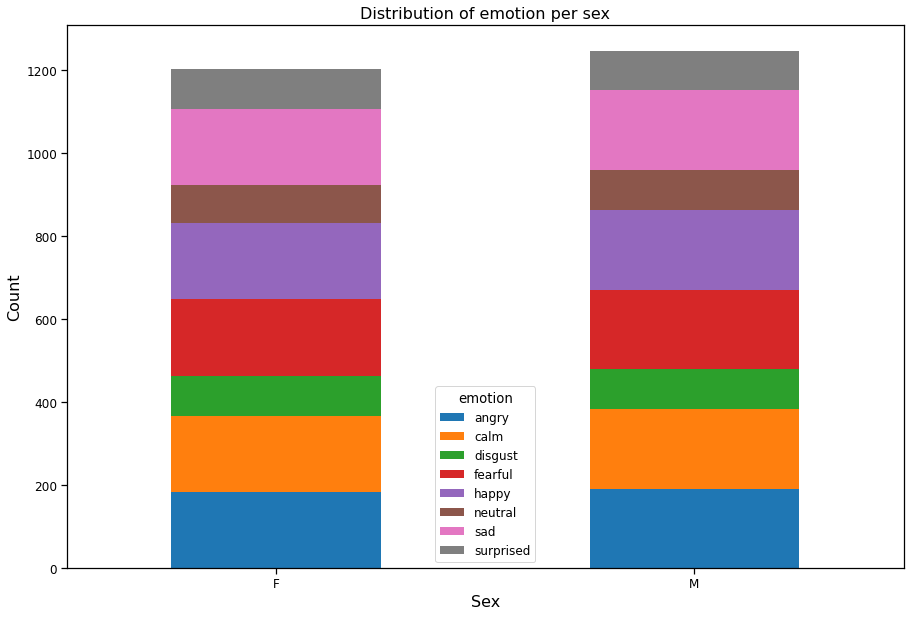

In [29]:
sns.set_context("notebook", font_scale = 1.1, rc = {"font.size": 16, "axes.titlesize": 16, "axes.labelsize": 16}) # set the
# context of chart, in this case this is a notebook, and some other size and scale
plt.rcParams["figure.figsize"] = [15, 10] # it configures the size of chart (x and y axes)

# stacked chart of vocal channel per sex
emotion_sex.plot(kind="bar", stacked = True)
plt.title("Distribution of emotion per sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.xticks(rotation = 0)
#plt.savefig("stacked_vocalChannel.png") # it saves the chart as .png image
plt.show()

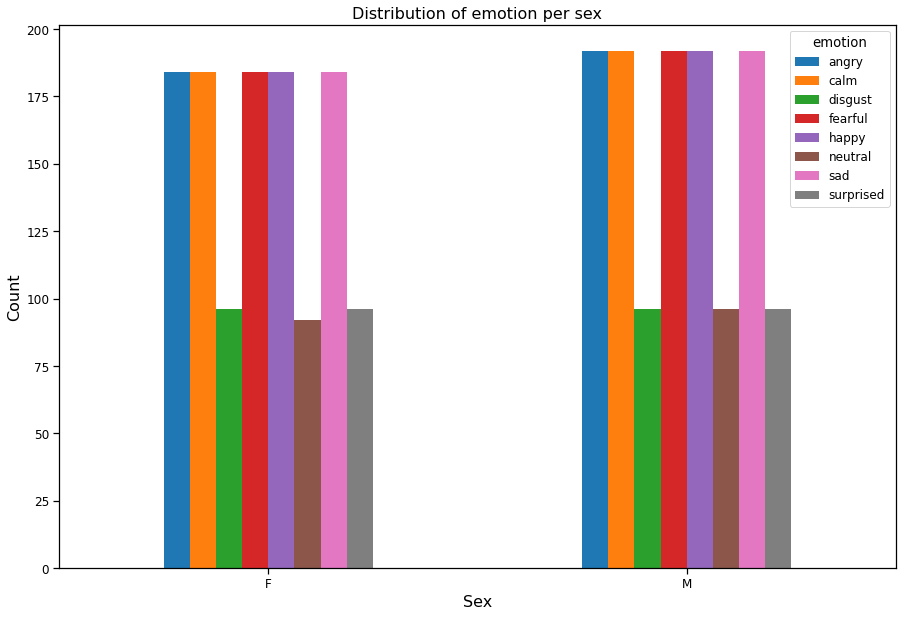

In [30]:
sns.set_context("notebook", font_scale = 1.1, rc = {"font.size": 16, "axes.titlesize": 16, "axes.labelsize": 16}) # set the
# context of chart, in this case this is a notebook, and some other size and scale
plt.rcParams["figure.figsize"] = [15, 10] # it configures the size of chart (x and y axes)

# stacked chart of vocal channel per sex
emotion_sex.plot(kind="bar", stacked = False)
plt.title("Distribution of emotion per sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.xticks(rotation = 0)
#plt.savefig("stacked_vocalChannel.png") # it saves the chart as .png image
plt.show()

In [31]:
vocal_channel = pd.crosstab(df["sex"], df["vocal_channel"])
vocal_channel

vocal_channel,song,speech
sex,,
F,434,671
M,487,664


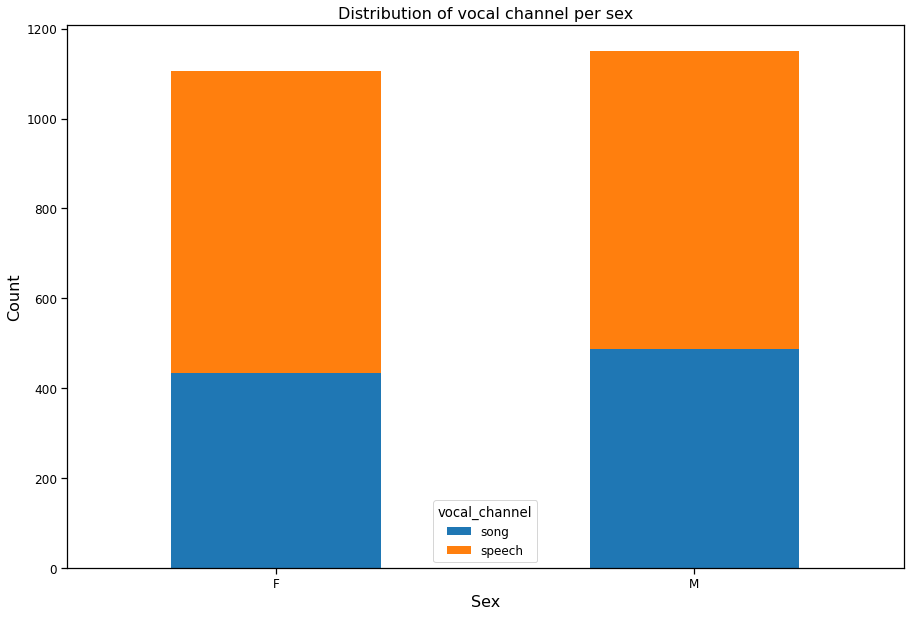

In [32]:
# stacked chart of vocal channel per sex
vocal_channel.plot(kind="bar", stacked = True)
plt.title("Distribution of vocal channel per sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.xticks(rotation = 0)
#plt.savefig("stacked_vocalChannel.png") # it saves the chart as .png image
plt.show()

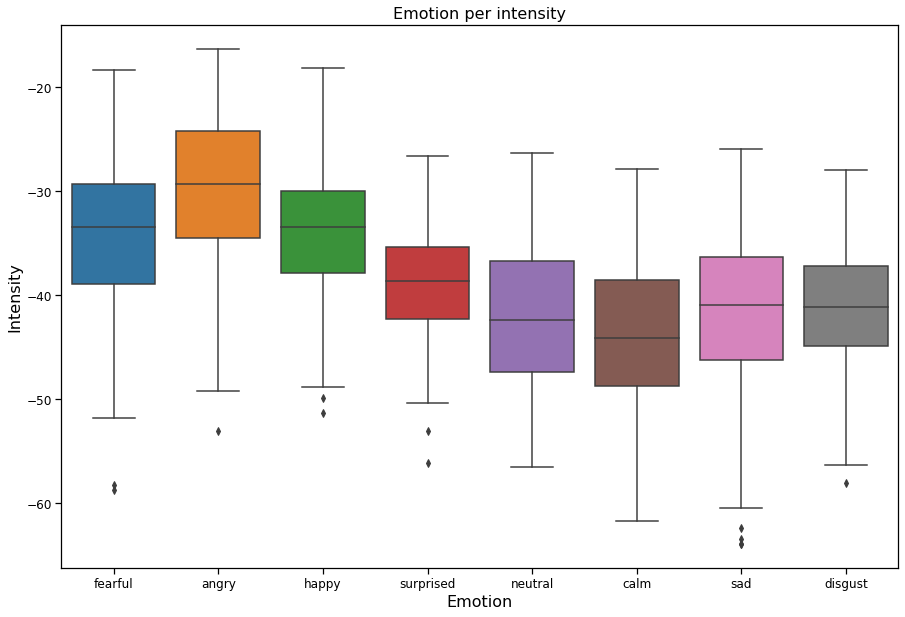

In [33]:
sns.boxplot(x = "emotion", y = "intensity", data = df)
plt.title("Emotion per intensity")
plt.xlabel("Emotion")
plt.ylabel("Intensity")
#plt.savefig("boxplot_emotionIntensity.png")
plt.show()

In [34]:
sizes = df["emotion"].value_counts()
labels = df["emotion"].unique()

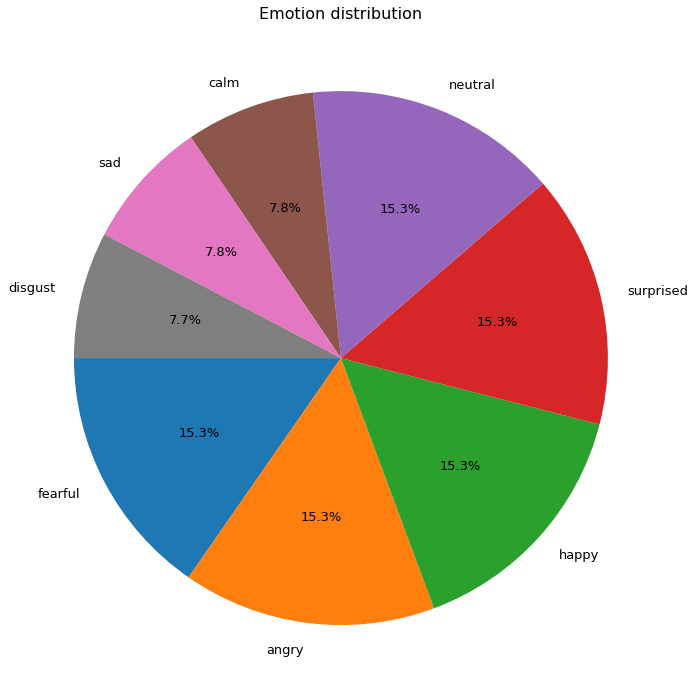

In [35]:
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 180, textprops = {'fontsize': 13})
plt.title("Emotion distribution")
plt.tight_layout() # it fixes padding around the chart
#plt.savefig("pie_emotion.png")
plt.show()

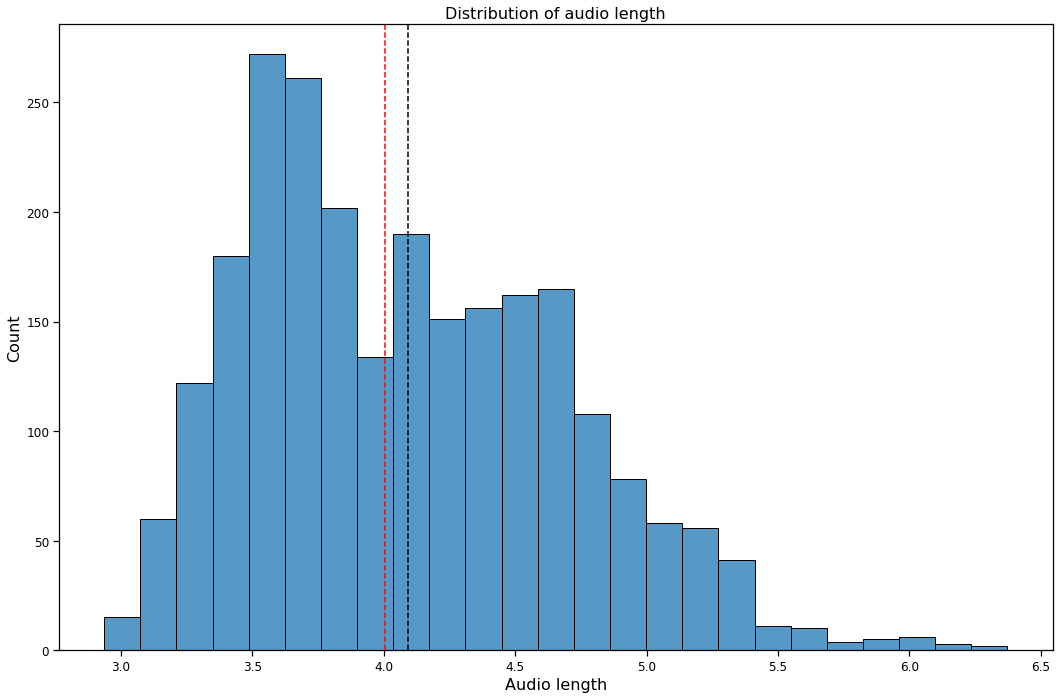

In [36]:
sns.histplot(df["length"])
plt.title("Distribution of audio length")
plt.xlabel("Audio length")
plt.ylabel("Count")
plt.axvline(df['length'].mean(), color = "k", linestyle = "--") # mean (black dotted line)
plt.axvline(df['length'].median(), color = "r", linestyle = "--") # median (red dotted line)
plt.tight_layout()
#plt.savefig("histplot_lenghtms.png")
plt.show()

In [37]:
emoInt_sex = pd.crosstab(df["sex"], df["emotional_intensity"])
emoInt_sex

emotional_intensity,normal,strong
sex,,
F,648,556
M,672,576


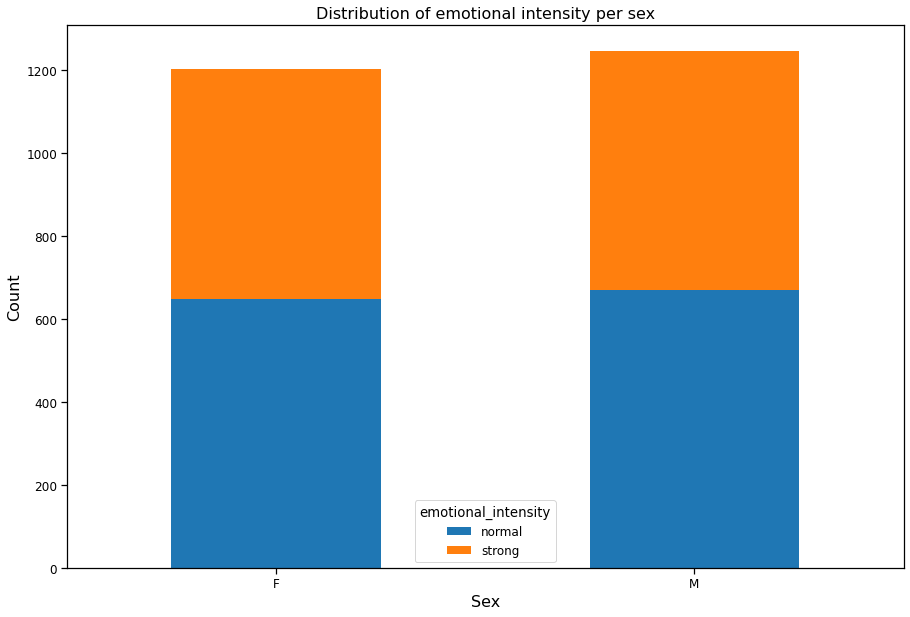

In [38]:
# stacked chart of emotional intensity per sex
emoInt_sex.plot(kind="bar", stacked = True)
plt.title("Distribution of emotional intensity per sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.xticks(rotation = 0)
#plt.savefig("stacked_vocalChannel.png") # it saves the chart as .png image
plt.show()

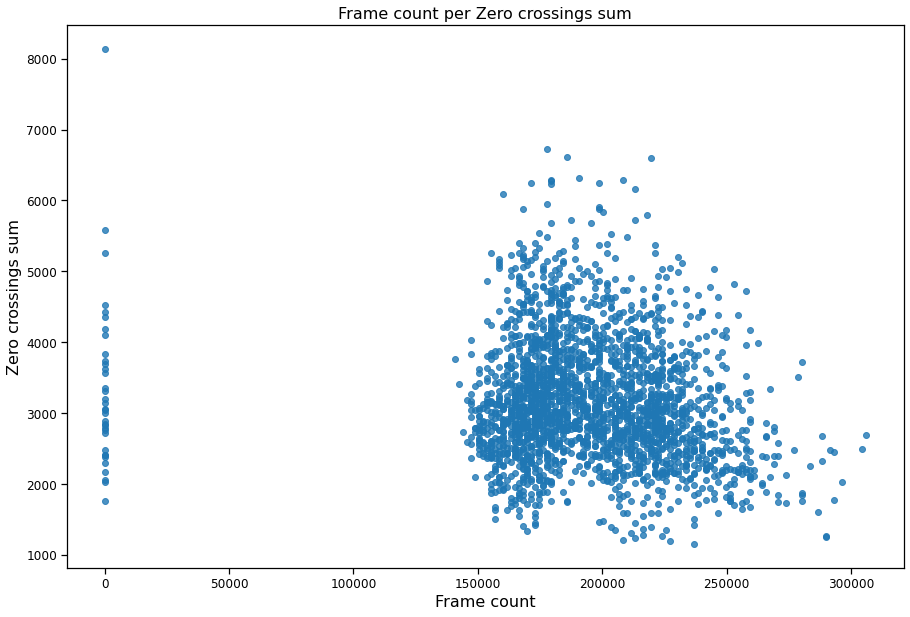

In [39]:
sns.regplot(x = "frame_count", y = "zero_crossings_rate", fit_reg = False, data = df)
plt.title("Frame count per Zero crossings sum")
plt.xlabel("Frame count")
plt.ylabel("Zero crossings sum")
#plt.savefig("scatter_fc-zcs.png")
plt.show()

Here we can notice a missing frame count or uncorrect entries, because there are some 0 values on _frame count_ axis.

**Calculate the outliers with interpolation.**

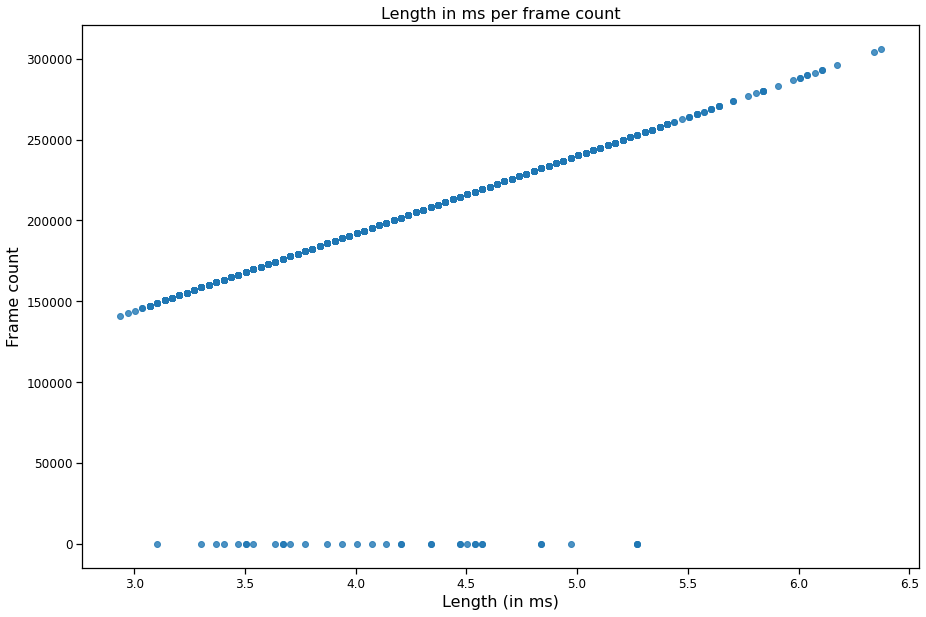

In [40]:
sns.regplot(x = "length", y = "frame_count", fit_reg = False, data = df)
plt.title("Length in ms per frame count")
plt.xlabel("Length (in ms)")
plt.ylabel("Frame count")
#plt.savefig("scatter_lms-fc.png")
plt.show()

In [41]:
df = df.drop(columns=["frame_count"])

Also here we can see there are some uncorrect or missing values on _frame count_ axis.

**Calculate the outliers with interpolation.**

In [42]:
EI_stat = pd.crosstab(df["emotional_intensity"], df["statement"])
EI_stat

statement,Dogs are sitting by the door,Kids are talking by the door
emotional_intensity,,
normal,660,660
strong,566,566


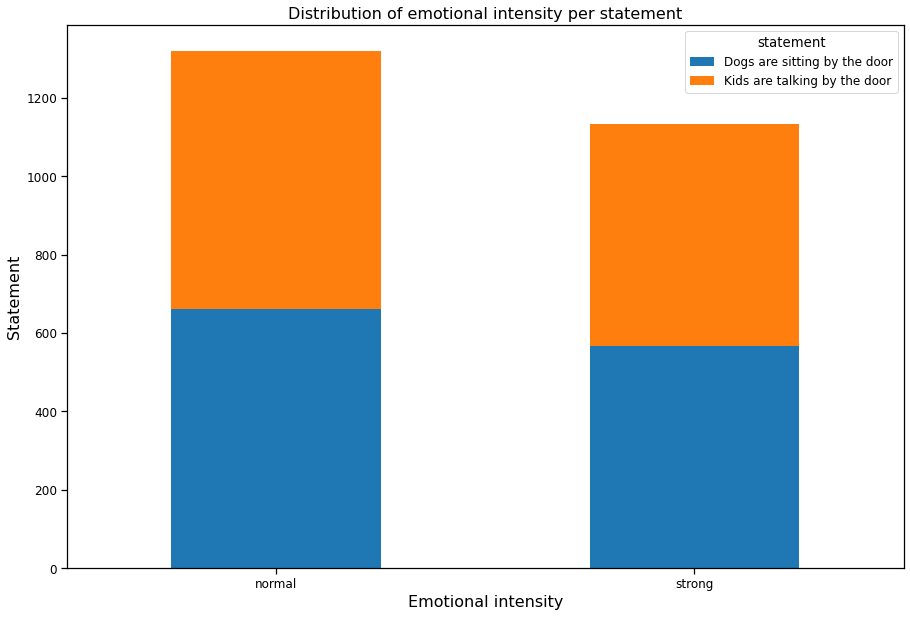

In [43]:
EI_stat.plot(kind="bar", stacked = True)
plt.title("Distribution of emotional intensity per statement")
plt.xlabel("Emotional intensity")
plt.ylabel("Statement")
plt.xticks(rotation = 0)
#plt.savefig("stacked_EI-stat.png")
plt.show()

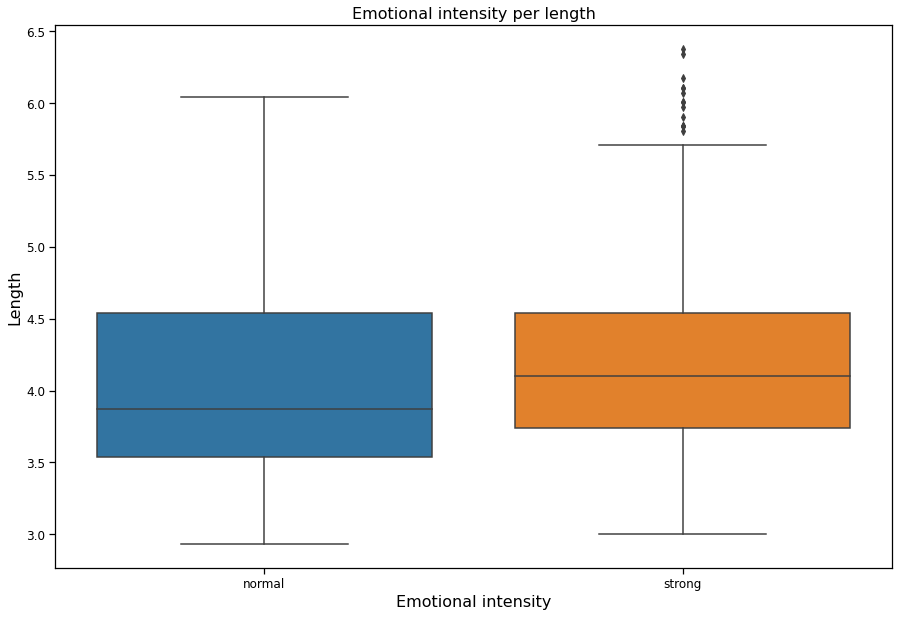

In [44]:
sns.boxplot(x = "emotional_intensity", y = "length", data = df)
plt.title("Emotional intensity per length")
plt.xlabel("Emotional intensity")
plt.ylabel("Length")
#plt.savefig("boxplot_EI-length.png")
plt.show()

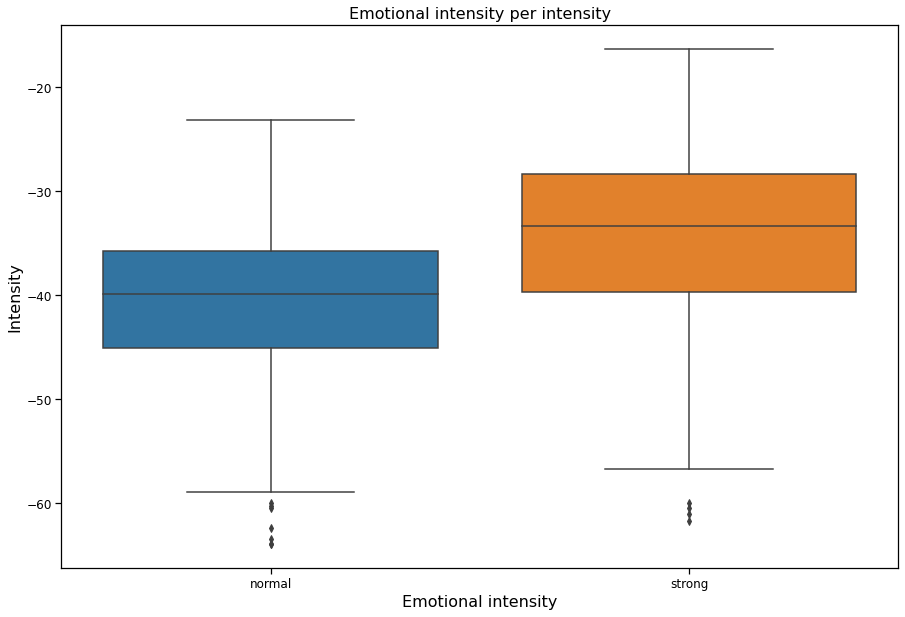

In [45]:
sns.boxplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

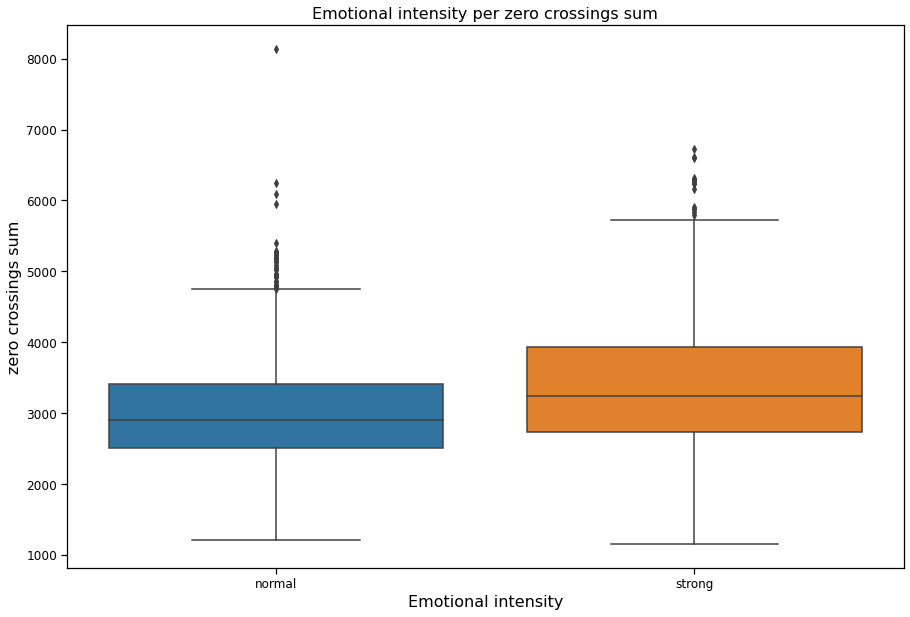

In [46]:
sns.boxplot(x = "emotional_intensity", y = "zero_crossings_rate", data = df)
plt.title("Emotional intensity per zero crossings sum")
plt.xlabel("Emotional intensity")
plt.ylabel("zero crossings sum")
#plt.savefig("boxplot_EI-ZCS.png")
plt.show()

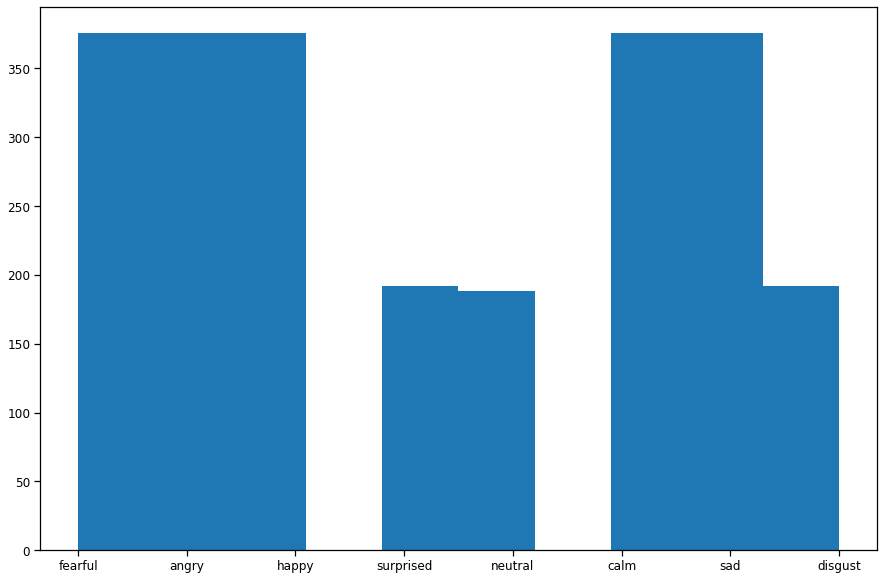

In [47]:
plt.hist(df.emotion)
plt.show()

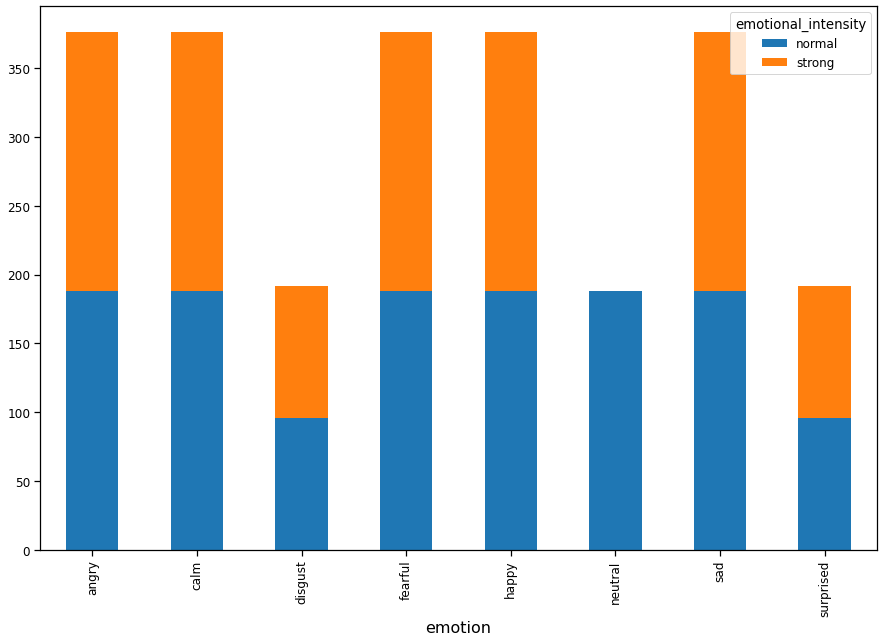

In [48]:
em_intensity_em = pd.crosstab(df["emotion"],df["emotional_intensity"])
em_intensity_em.plot(kind="bar", stacked = True)
plt.show()

In [49]:
df['statement'] = df['statement'].replace(['Dogs are sitting by the door'], '0')
df['statement'] = df['statement'].replace(['Kids are talking by the door'], '1')

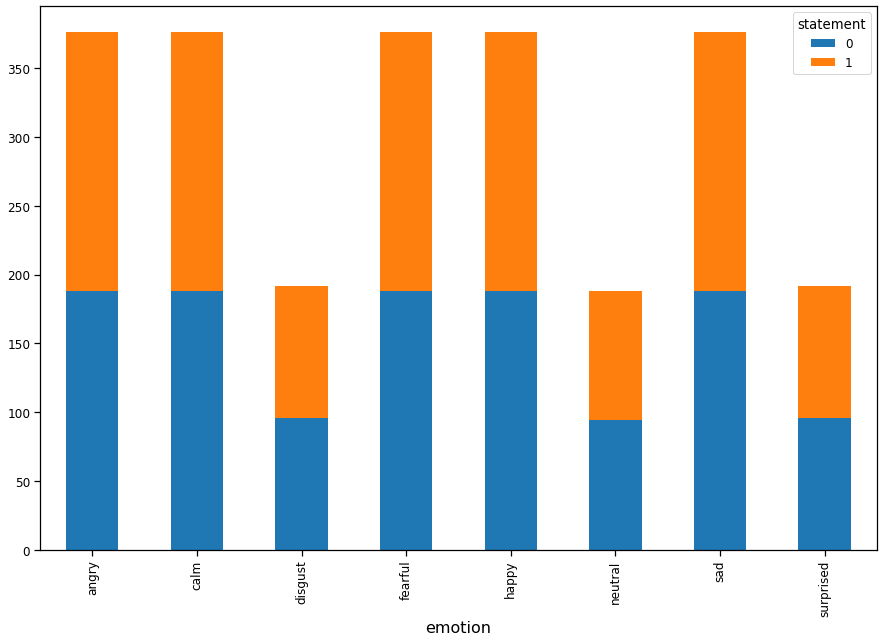

In [50]:
em_stat = pd.crosstab(df.emotion,df.statement)
em_stat.plot(kind = 'bar', stacked = True)
plt.show()

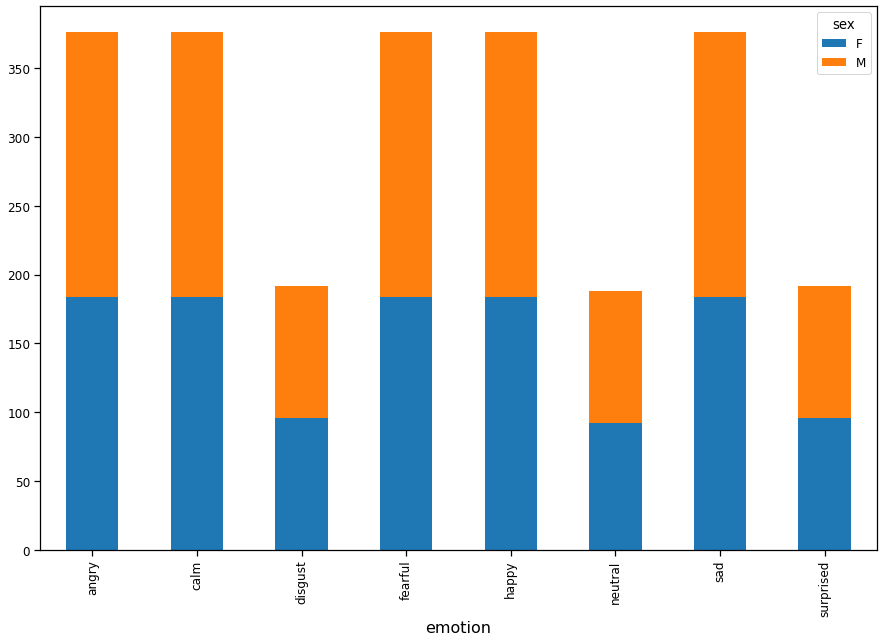

In [51]:
em_sex = pd.crosstab(df.emotion,df.sex)
em_sex.plot(kind="bar",stacked = True)
plt.show()

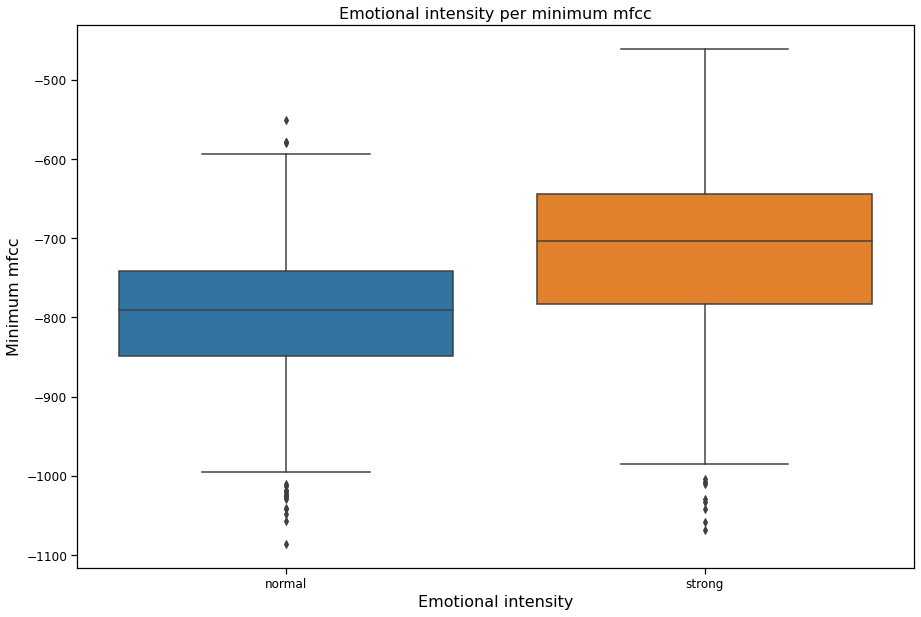

In [52]:
sns.boxplot(x = "emotional_intensity", y = "mfcc_min", data = df)
plt.title("Emotional intensity per minimum mfcc")
plt.xlabel("Emotional intensity")
plt.ylabel("Minimum mfcc")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

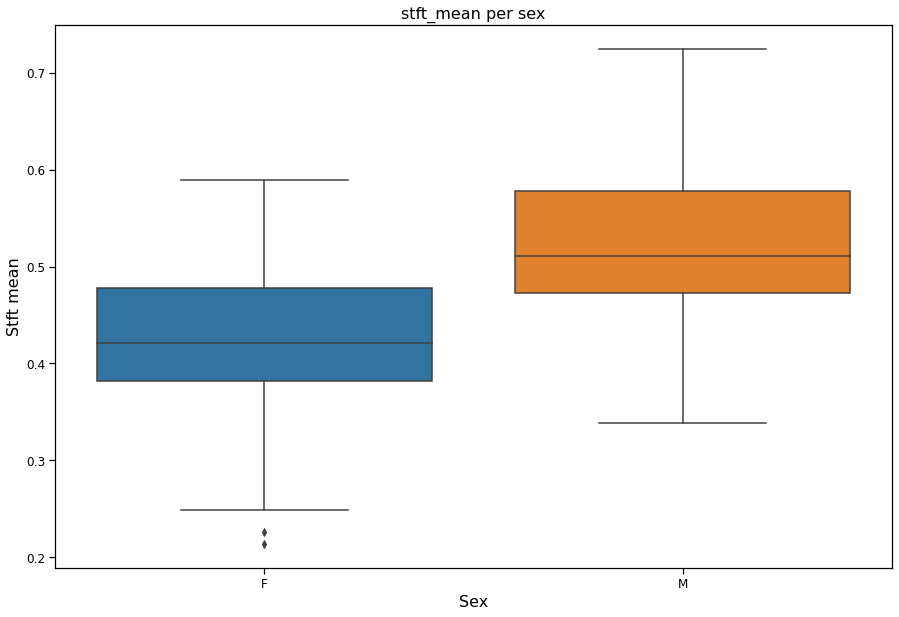

In [53]:
sns.boxplot(x = "sex", y = "stft_mean", data = df)
plt.title("stft_mean per sex")
plt.xlabel("Sex")
plt.ylabel("Stft mean")
#plt.savefig("boxplot_EI-minMFCC.png")
plt.show()

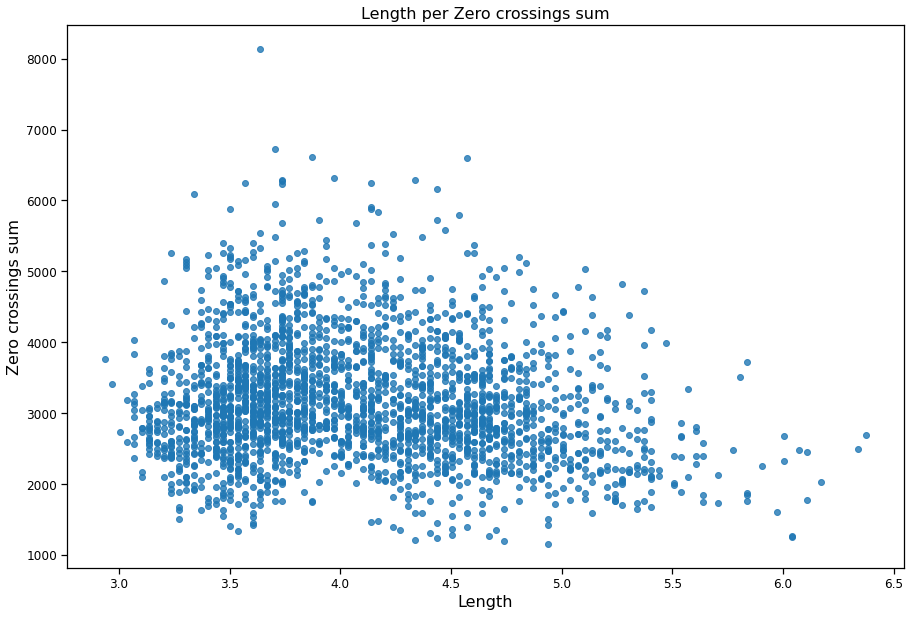

In [54]:
sns.regplot(x = "length", y = "zero_crossings_rate", fit_reg = False, data = df)
plt.title("Length per Zero crossings sum")
plt.xlabel("Length")
plt.ylabel("Zero crossings sum")
#plt.savefig("scatter_fc-zcs.png")
plt.show()

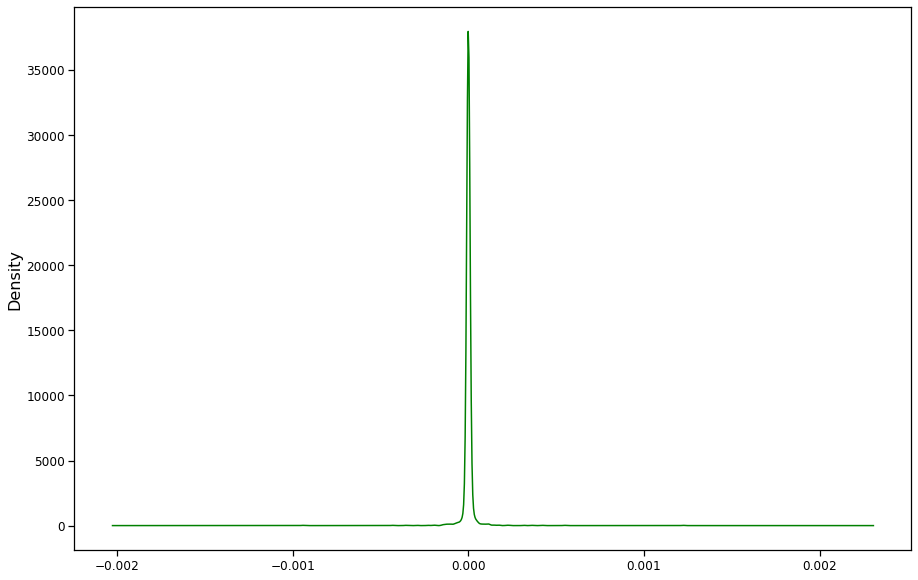

In [55]:
density = df["mean"].plot.density(color='green')

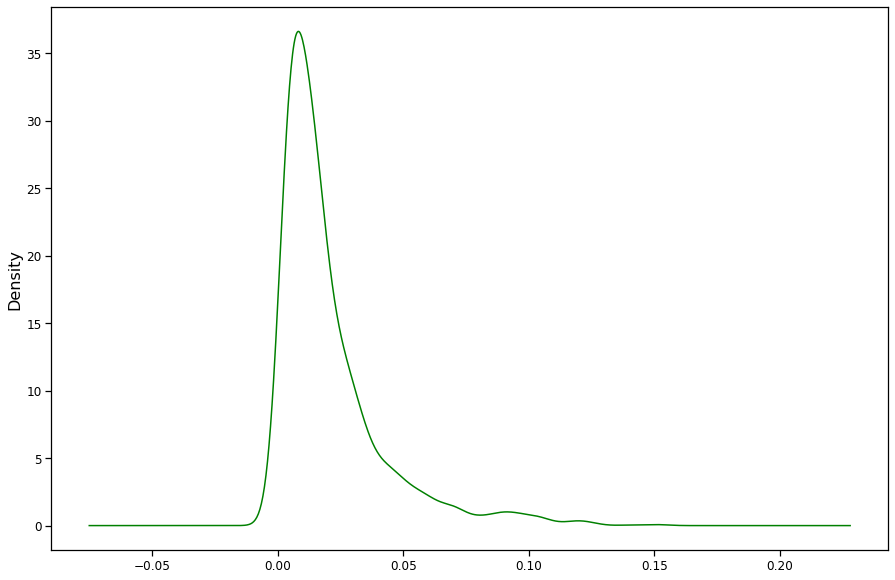

In [56]:
df["std"].plot.kde(color='green')
plt.show()

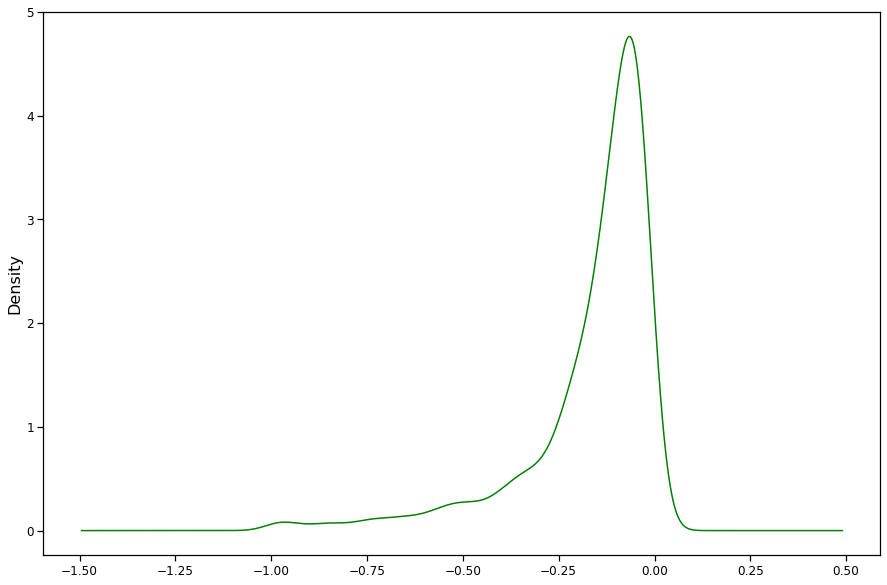

In [57]:
df["min"].plot.kde(color='green')
plt.show()

In [58]:
#plt.scatter(df["max"],df["stft_max"])
#plt.show()

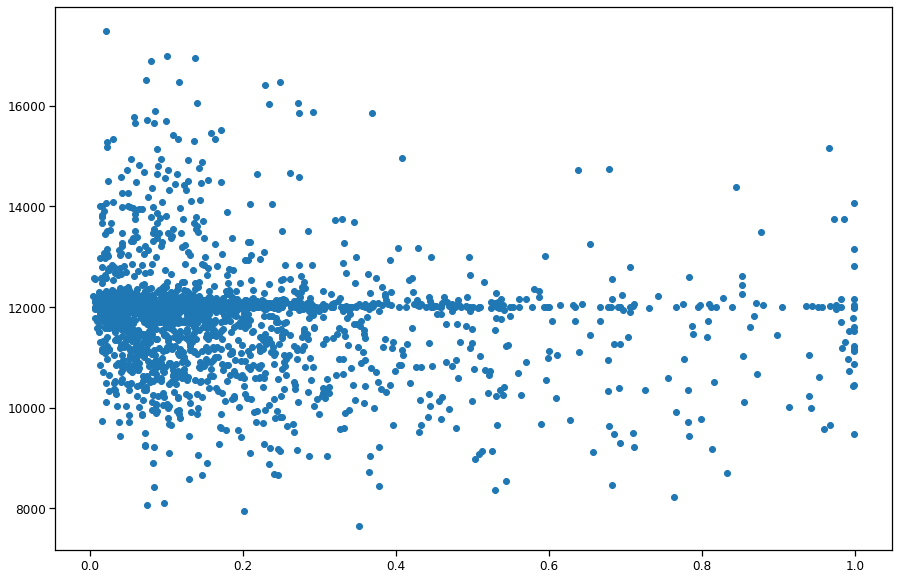

In [59]:
plt.scatter(df["max"],df["sc_max"])
plt.show()

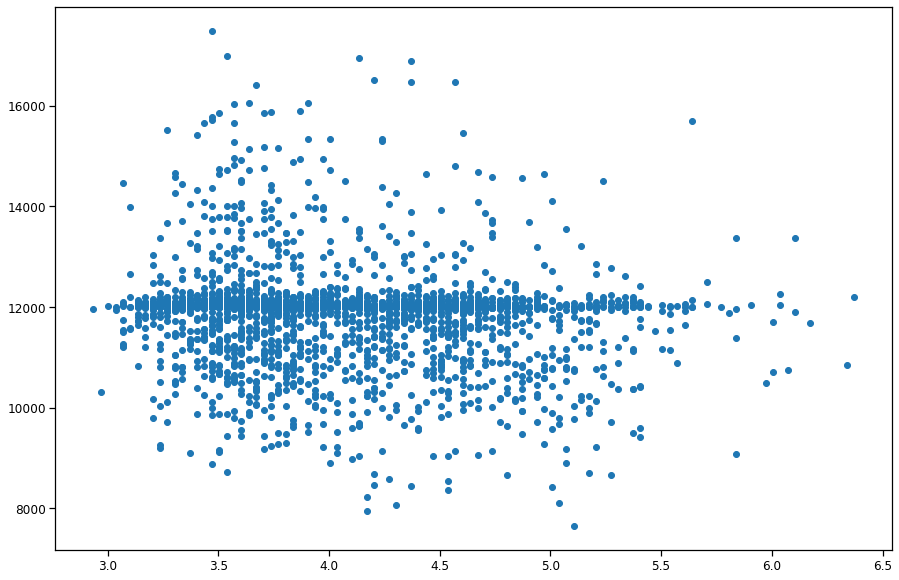

In [60]:
plt.scatter(df["length"],df["sc_max"])
plt.show()

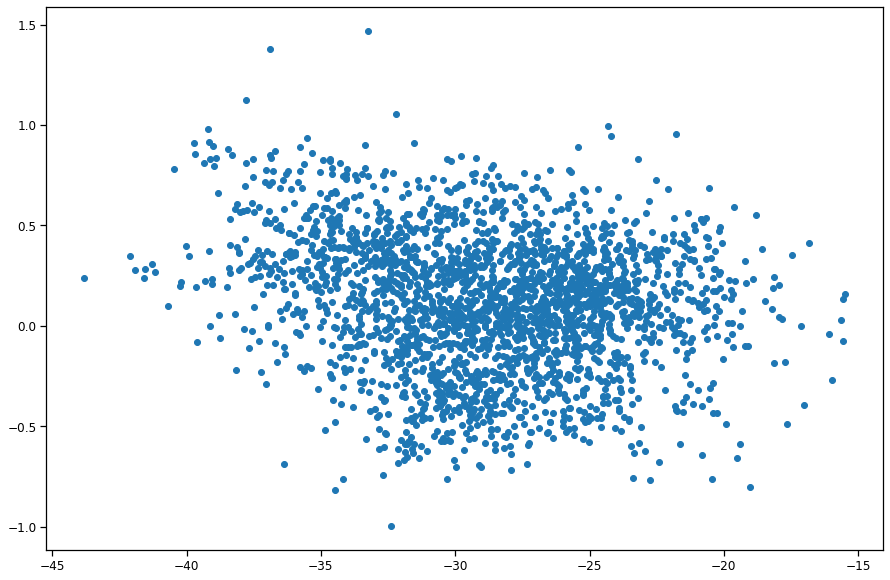

In [61]:
plt.scatter(df["mfcc_mean"],df["stft_skew"])
plt.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_13788/2346075027.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


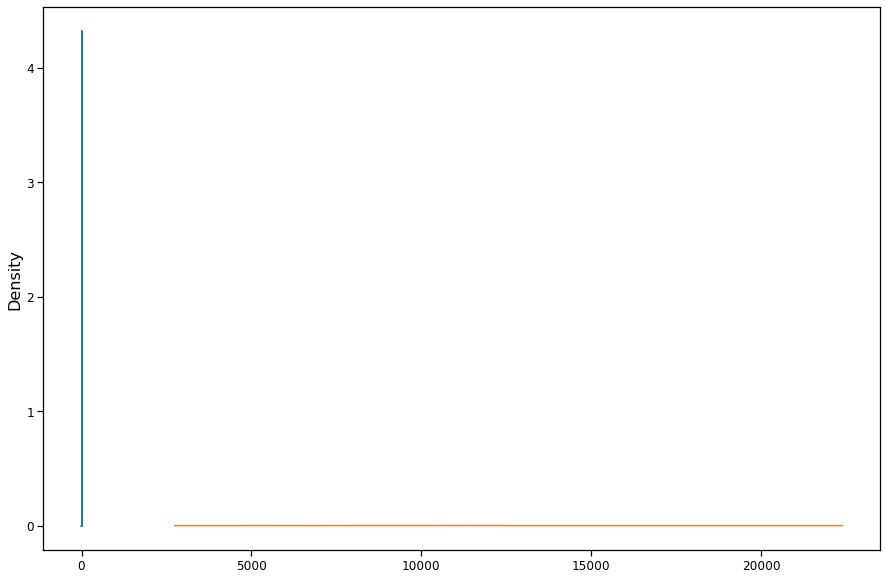

In [62]:
max_features = df[["max","sc_max"]]
fig, ax = plt.subplots(1,1)
for s in max_features.columns:
    df[s].plot(kind='density')
fig.show()

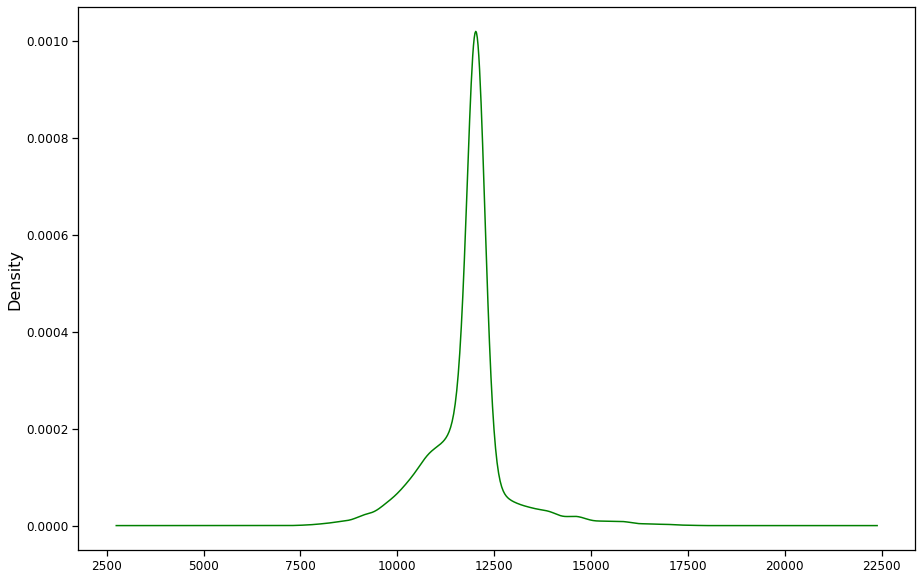

In [63]:
df["sc_max"].plot.kde(color='green')
plt.show()

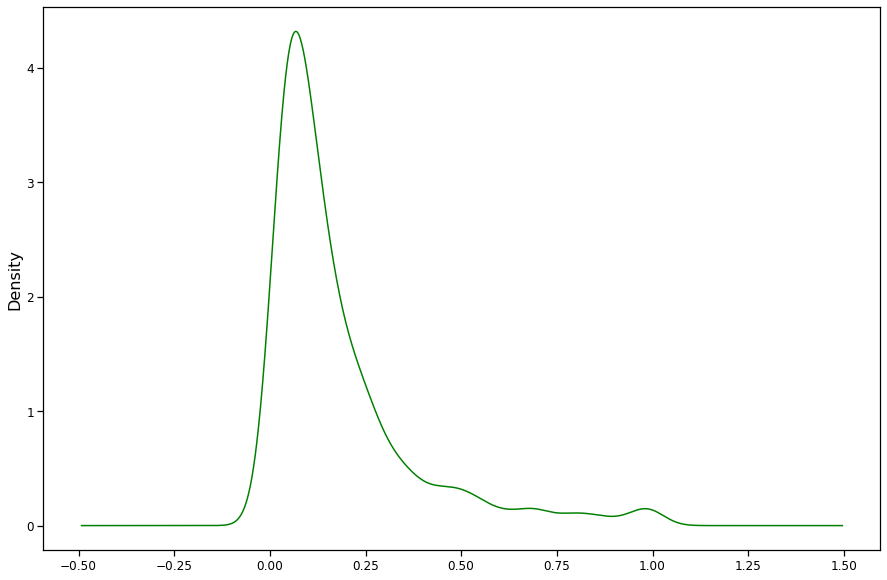

In [64]:
df["max"].plot.kde(color='green')
plt.show()

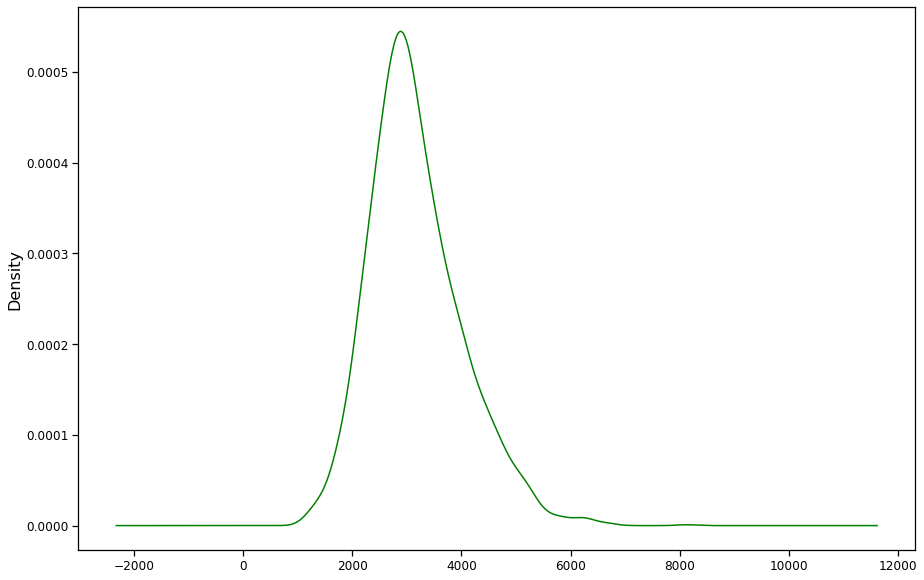

In [65]:
df["zero_crossings_rate"].plot.kde(color='green')
plt.show()

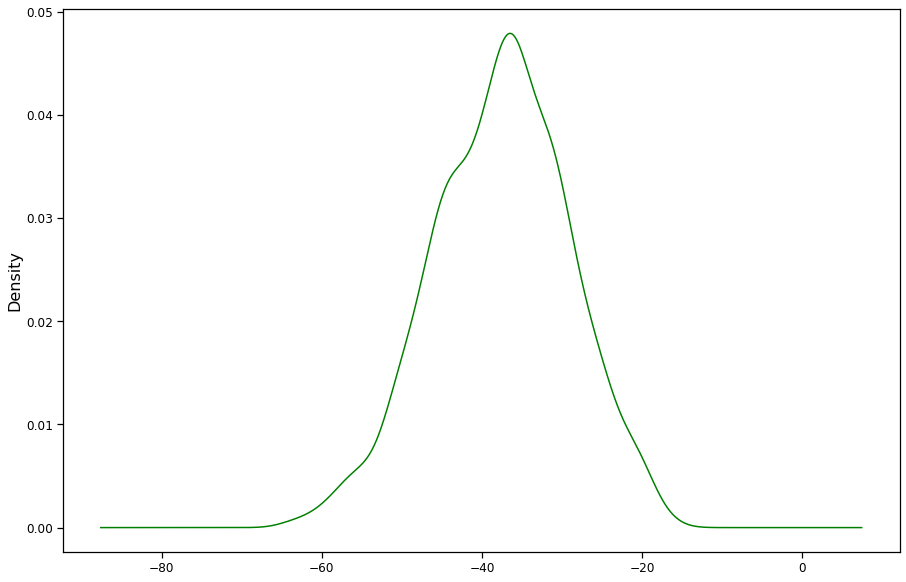

In [66]:
df["intensity"].plot.kde(color='green')
plt.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_13788/2196359511.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


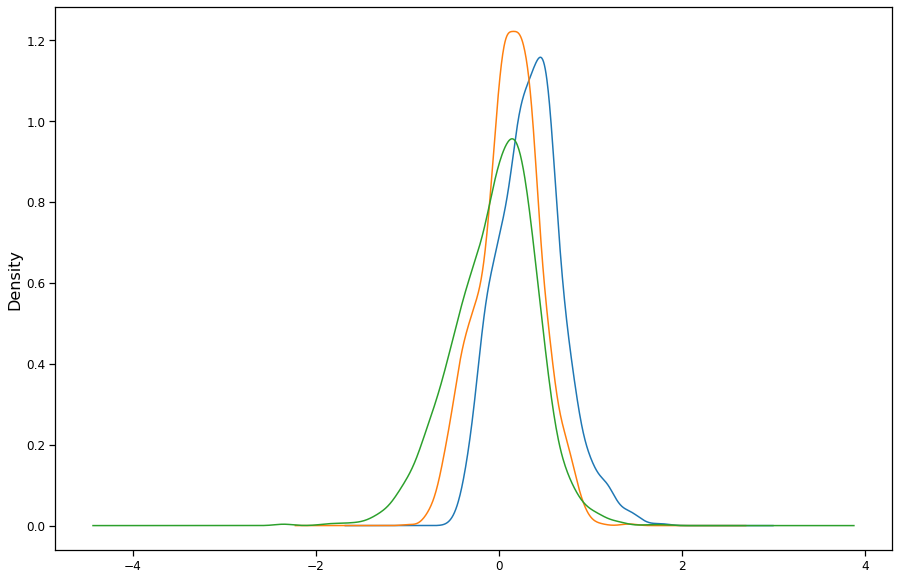

In [67]:
skew_features = df[["sc_skew","stft_skew","skew"]]
fig, ax = plt.subplots(1,1)
for s in skew_features.columns:
    df[s].plot(kind='density')
fig.show()

C:\Users\claud\AppData\Local\Temp/ipykernel_13788/2833179634.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


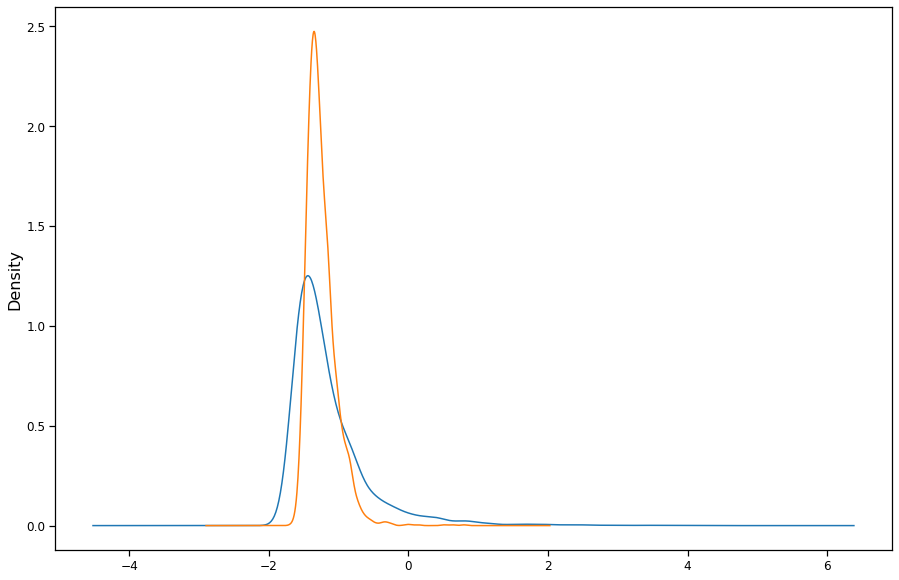

In [68]:
kur_features = df[["sc_kur","stft_kur"]]
fig, ax = plt.subplots(1,1)
for s in kur_features.columns:
    df[s].plot(kind='density')
fig.show()

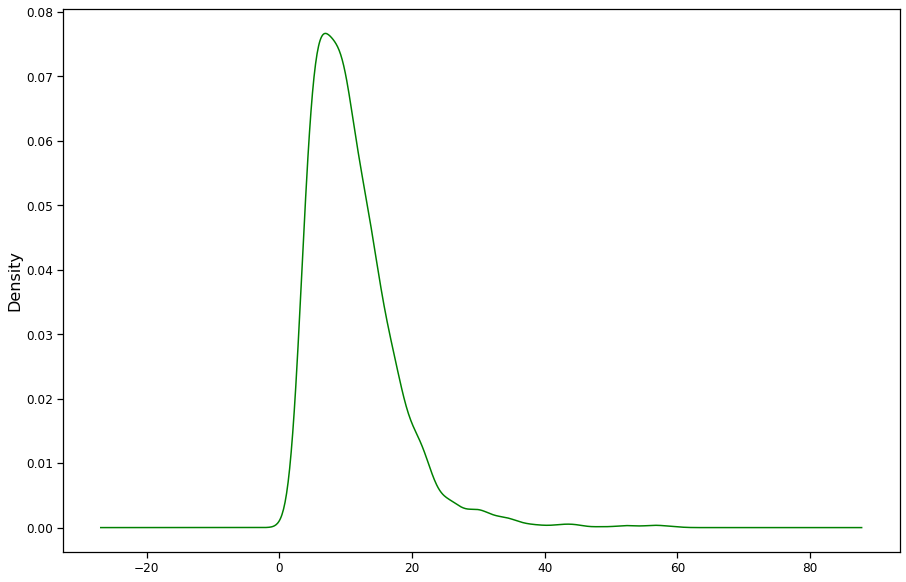

In [69]:
df["kur"].plot.kde(color='green')
plt.show()

Frame count: interpolation

Missing values: 
Vocal channel...


## Outliers - Single attribute

**Definition of outliers computation**

In [70]:
def outliers(variable) :
    Q1 = df[variable].quantile(0.25, interpolation = 'linear')
    Q3 = df[variable].quantile(0.75, interpolation = 'linear')
    IQR = Q3 - Q1
    Lowerfence = Q1 - 1.5*IQR
    Upperfence = Q3 + 1.5*IQR
    OUTLIERS = df.loc[(df[variable] < Lowerfence)  |  (df[variable] > Upperfence) ]
    NORMAL_Spec = df.loc[(df[variable] > Lowerfence)  & (df[variable] < Upperfence) ]
    return OUTLIERS[variable].round(2)

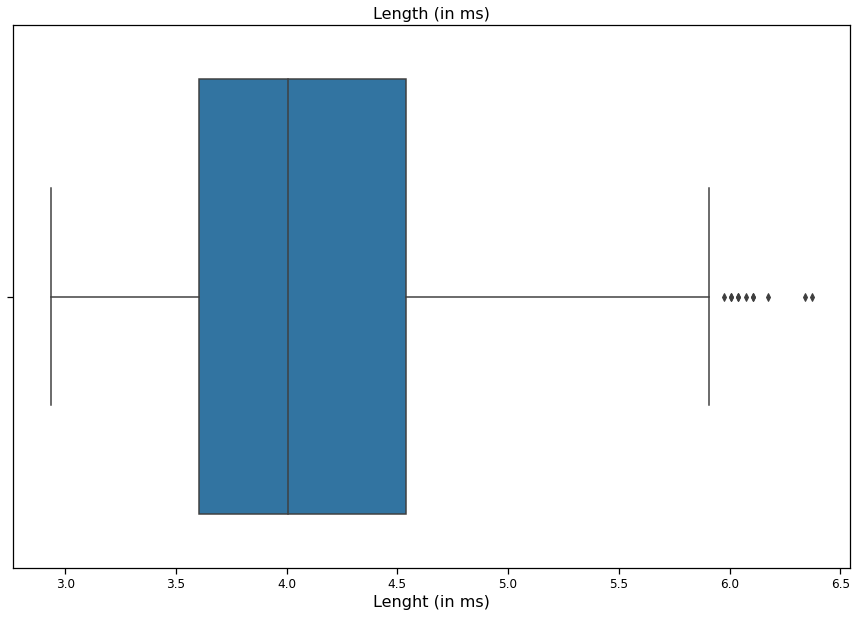

In [71]:
sns.boxplot(x = "length", data = df)
plt.title("Length (in ms)")
plt.xlabel("Lenght (in ms)")
#plt.savefig("boxplot_length.png")
plt.show()

In [72]:
print(outliers("length"))

61      6.37
435     6.11
739     6.01
959     6.11
1292    6.17
1438    6.34
1617    6.07
1777    6.04
1791    5.97
1922    6.01
2158    6.04
Name: length, dtype: float64


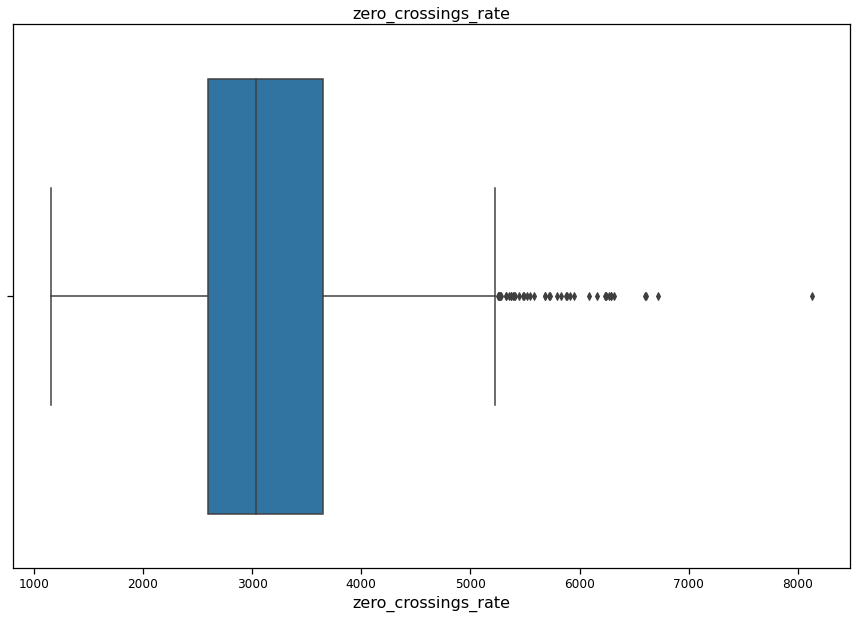

In [73]:
sns.boxplot(x = "zero_crossings_rate", data = df)
plt.title("zero_crossings_rate")
plt.xlabel("zero_crossings_rate")
#plt.savefig("boxplot_length.png")
plt.show()

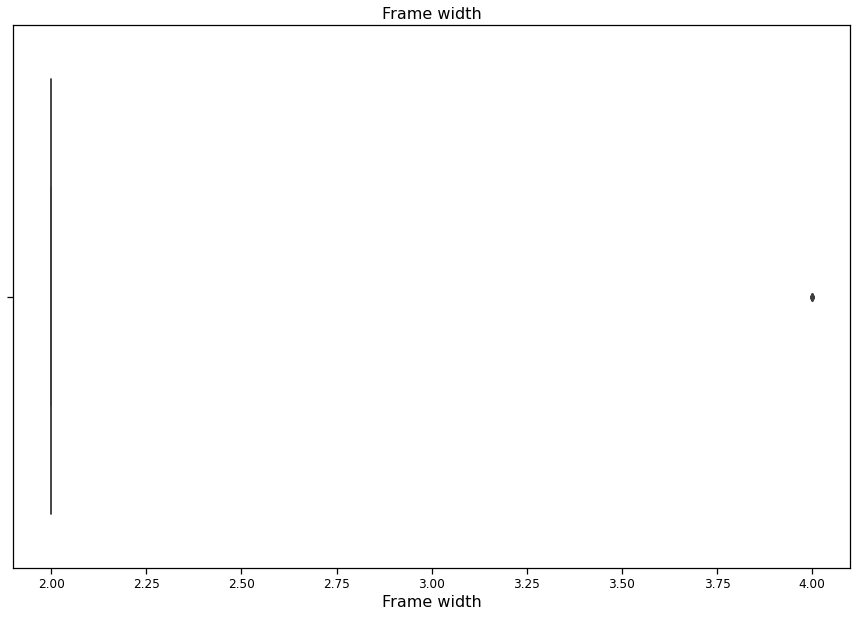

In [74]:
sns.boxplot(x = "frame_width", data = df)
plt.title("Frame width")
plt.xlabel("Frame width")
#plt.savefig("boxplot_frameWidth.png")
plt.show()

In [75]:
print(outliers("frame_width"))

287     4
778     4
1045    4
1336    4
1348    4
1809    4
Name: frame_width, dtype: int64


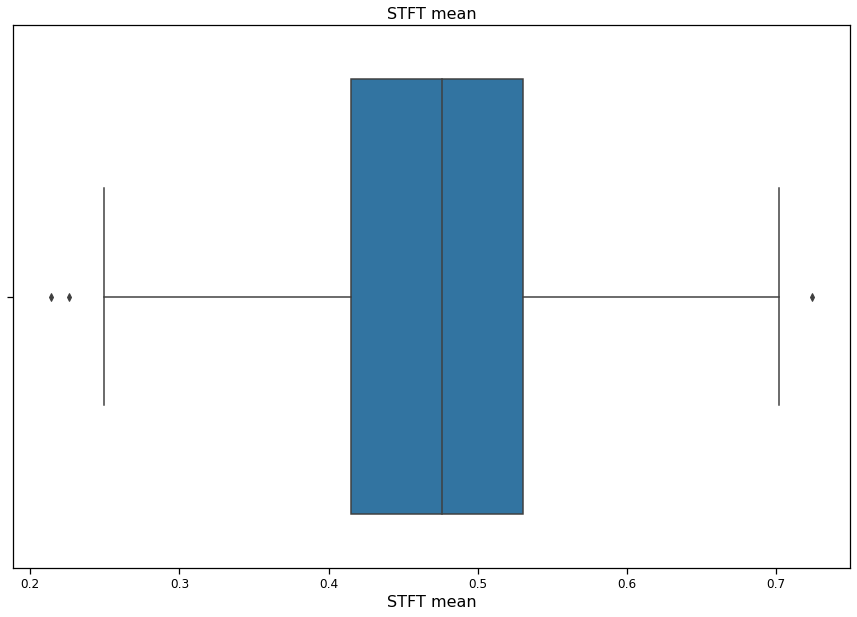

In [76]:
sns.boxplot(x = "stft_mean", data = df)
plt.title("STFT mean")
plt.xlabel("STFT mean")
#plt.savefig("boxplot_stftMean.png")
plt.show()

In [77]:
print(outliers("stft_mean"))

748     0.72
1438    0.23
2253    0.21
Name: stft_mean, dtype: float64


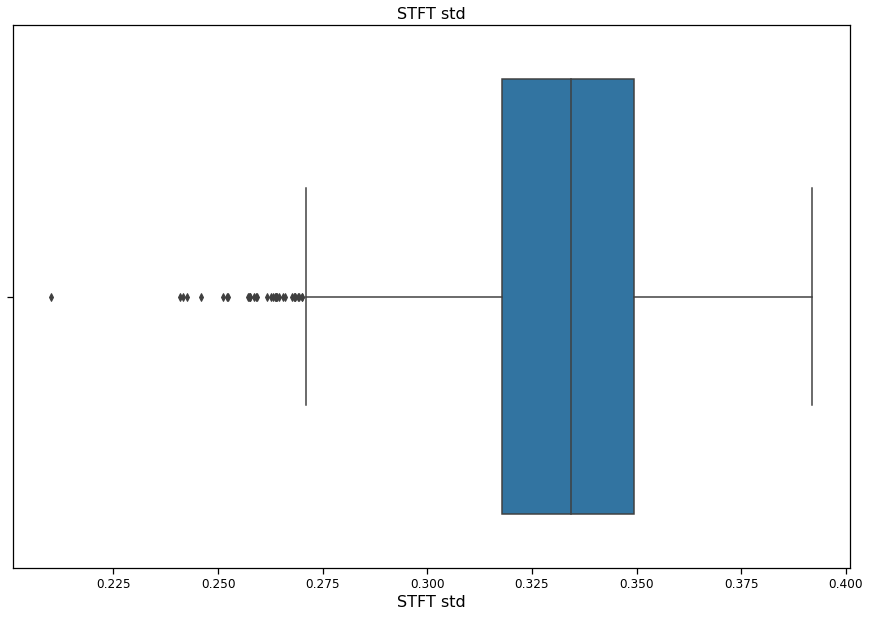

In [78]:
sns.boxplot(x = "stft_std", data = df)
plt.title("STFT std")
plt.xlabel("STFT std")
#plt.savefig("boxplot_stftSTD.png")
plt.show()

In [79]:
print(outliers("stft_std"))

149     0.26
171     0.26
209     0.26
419     0.26
433     0.26
444     0.26
446     0.26
448     0.24
455     0.26
475     0.26
508     0.27
741     0.26
748     0.21
749     0.27
1007    0.27
1060    0.27
1085    0.25
1123    0.25
1125    0.27
1233    0.27
1234    0.25
1253    0.27
1291    0.24
1489    0.27
1803    0.26
1843    0.25
1849    0.27
1855    0.26
2102    0.27
2119    0.26
2120    0.26
2141    0.24
2159    0.26
Name: stft_std, dtype: float64


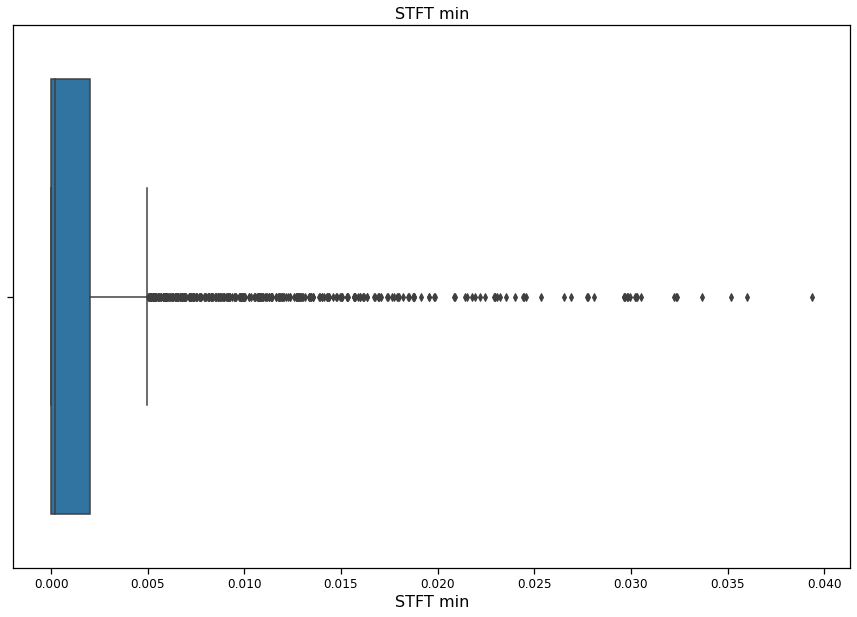

In [80]:
sns.boxplot(x = "stft_min", data = df)
plt.title("STFT min")
plt.xlabel("STFT min")
#plt.savefig("boxplot_stftMin.png")
plt.show()

In [81]:
print(outliers("stft_min")) # if the output is too long to visualize look at the "Length" property

60      0.01
69      0.01
75      0.01
84      0.01
85      0.01
        ... 
2438    0.01
2439    0.02
2440    0.01
2441    0.01
2444    0.02
Name: stft_min, Length: 336, dtype: float64


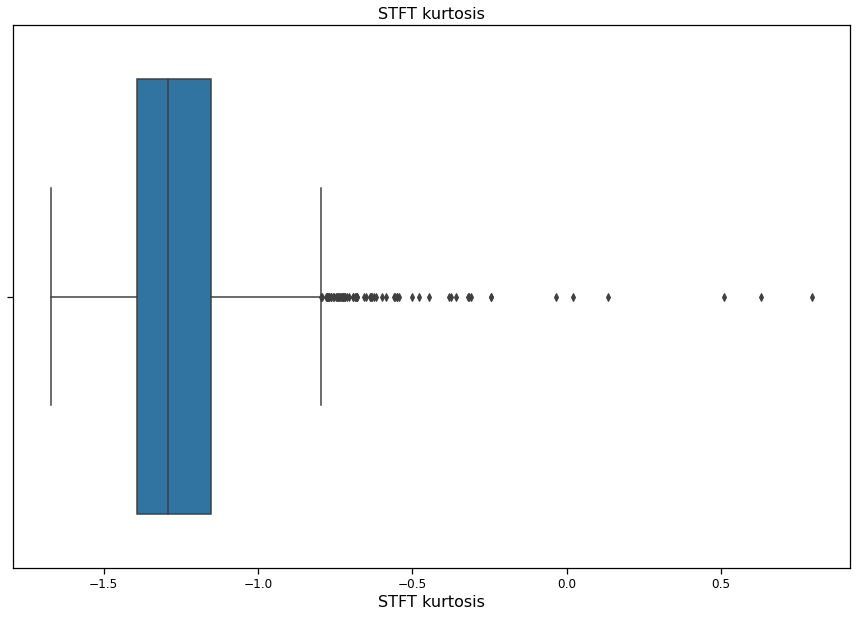

In [82]:
sns.boxplot(x = "stft_kur", data = df)
plt.title("STFT kurtosis")
plt.xlabel("STFT kurtosis")
#plt.savefig("boxplot_stftKur.png")
plt.show()

In [83]:
print(outliers("stft_kur"))

61     -0.36
119    -0.76
131    -0.64
149    -0.75
150    -0.76
        ... 
2345   -0.38
2372   -0.74
2374   -0.50
2424   -0.72
2438   -0.73
Name: stft_kur, Length: 69, dtype: float64


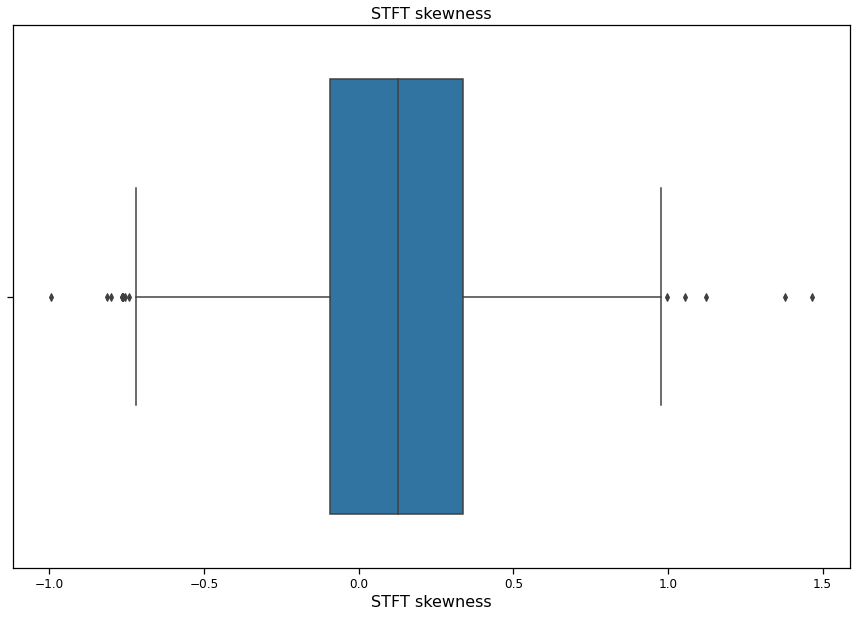

In [84]:
sns.boxplot(x = "stft_skew", data = df)
plt.title("STFT skewness")
plt.xlabel("STFT skewness")
#plt.savefig("boxplot_stftSkew.png")
plt.show()

In [85]:
print(outliers("stft_skew"))

61      1.05
131    -0.80
171    -0.74
1028   -0.76
1085   -0.76
1425    1.00
1438    1.38
1818   -0.76
1829   -0.81
2024    1.12
2068   -0.77
2141   -0.76
2159   -0.99
2253    1.47
Name: stft_skew, dtype: float64


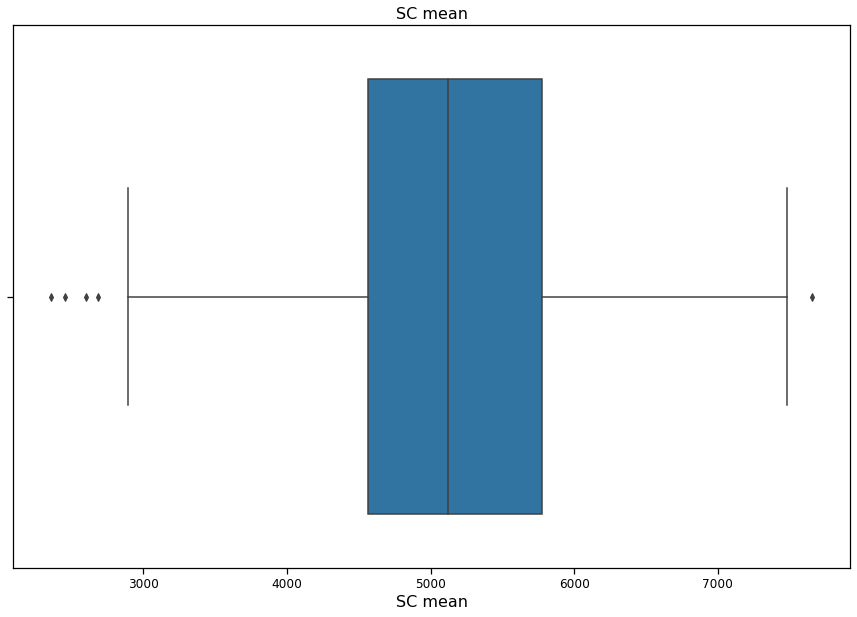

In [86]:
sns.boxplot(x = "sc_mean", data = df)
plt.title("SC mean")
plt.xlabel("SC mean")
#plt.savefig("boxplot_scMean.png")
plt.show()

In [87]:
print(outliers("sc_mean"))

1545    2684.60
1687    7655.34
1791    2360.88
2253    2454.04
2277    2604.36
Name: sc_mean, dtype: float64


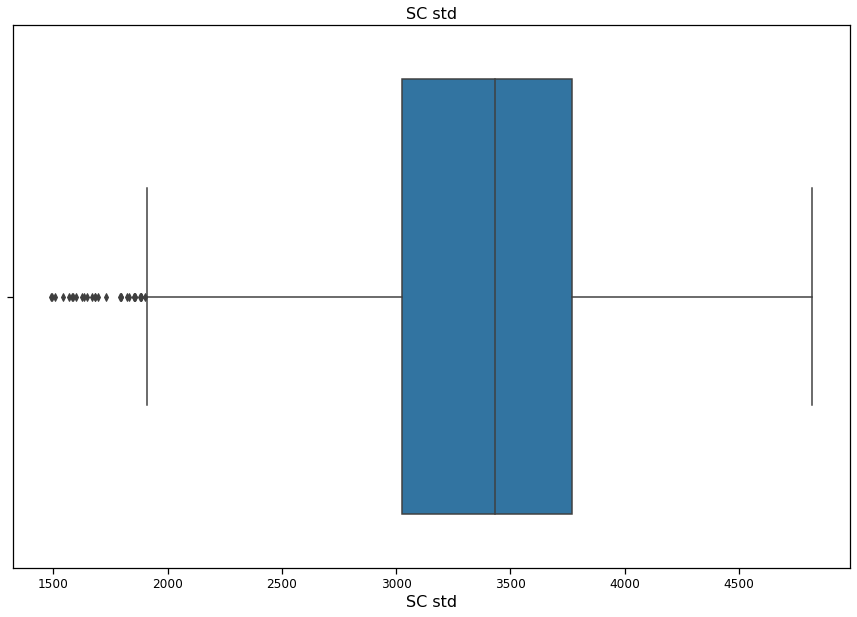

In [88]:
sns.boxplot(x = "sc_std", data = df)
plt.title("SC std")
plt.xlabel("SC std")
#plt.savefig("boxplot_scSTD.png")
plt.show()

In [89]:
print(outliers("sc_std"))

76      1885.50
113     1696.86
129     1832.49
154     1544.54
381     1852.68
439     1852.94
497     1684.75
521     1633.91
524     1568.52
525     1491.34
591     1649.18
680     1681.33
734     1881.94
803     1855.52
827     1795.03
834     1670.17
1077    1881.54
1187    1580.81
1425    1506.39
1480    1496.55
1545    1820.60
1799    1791.24
1851    1599.72
1868    1796.64
1897    1884.65
1992    1587.00
2137    1858.15
2395    1900.73
2396    1624.71
2403    1732.09
Name: sc_std, dtype: float64


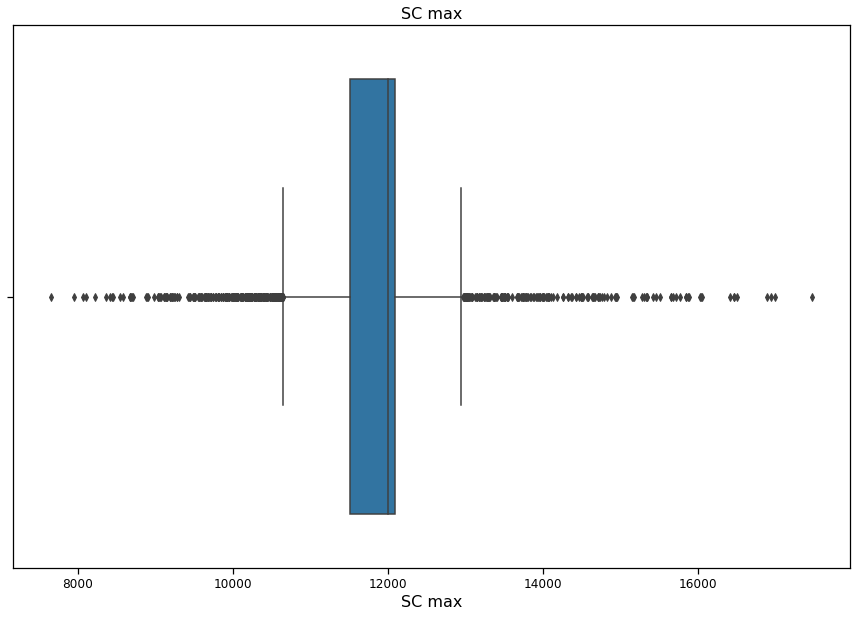

In [90]:
sns.boxplot(x = "sc_max", data = df)
plt.title("SC max")
plt.xlabel("SC max")
#plt.savefig("boxplot_scMax.png")
plt.show()

In [91]:
print(outliers("sc_max"))

0       13541.96
29      13315.14
35       9816.39
38      10321.26
40      13131.70
          ...   
2405     8698.88
2406     9443.33
2421     8907.59
2423    10439.88
2441    10365.49
Name: sc_max, Length: 439, dtype: float64


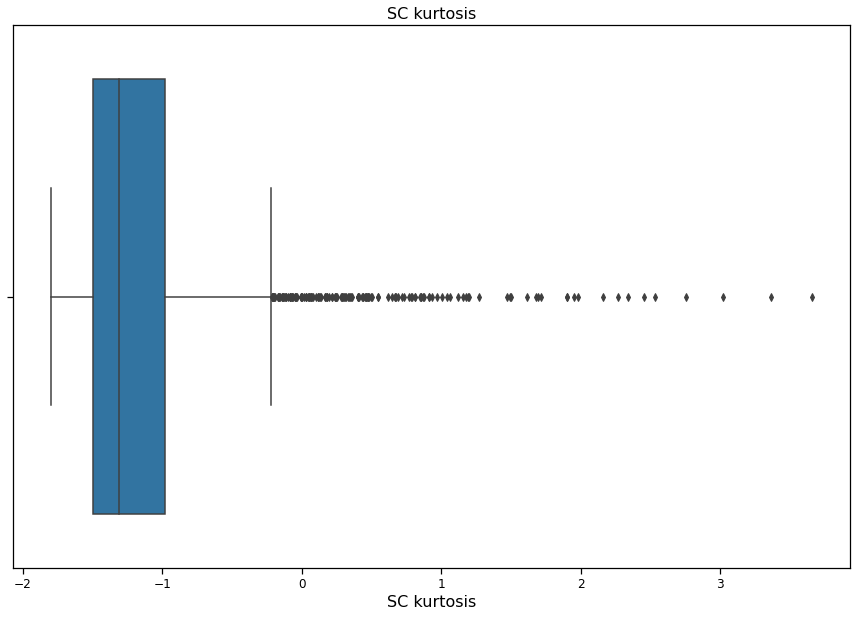

In [92]:
sns.boxplot(x = "sc_kur", data = df)
plt.title("SC kurtosis")
plt.xlabel("SC kurtosis")
#plt.savefig("boxplot_scKur.png")
plt.show()

In [93]:
print(outliers("sc_kur"))

36      0.41
37      0.45
42      0.36
58     -0.17
59      1.69
        ... 
2404    1.90
2420   -0.13
2436    0.81
2437    0.85
2442   -0.08
Name: sc_kur, Length: 152, dtype: float64


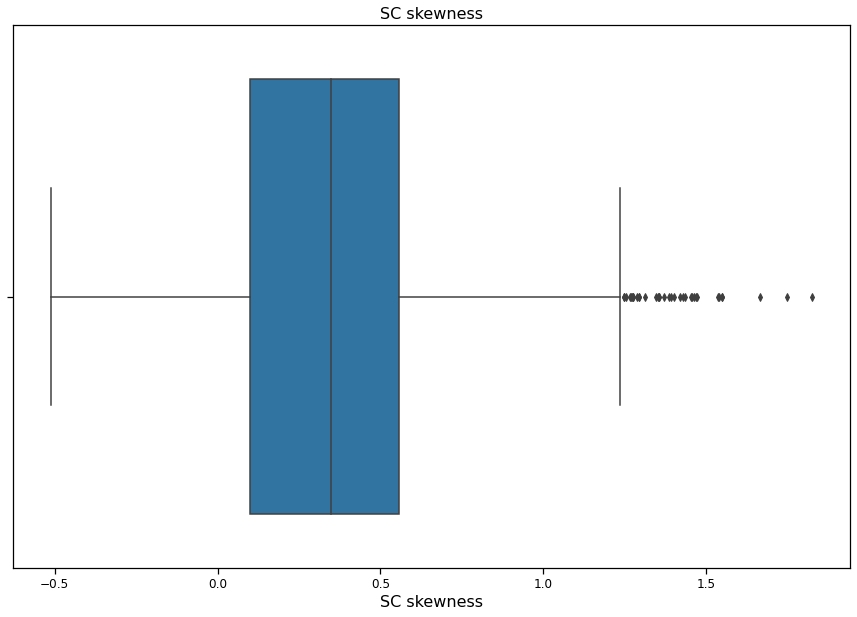

In [94]:
sns.boxplot(x = "sc_skew", data = df)
plt.title("SC skewness")
plt.xlabel("SC skewness")
#plt.savefig("boxplot_scSkew.png")
plt.show()

In [95]:
print(outliers("sc_skew"))

37      1.30
42      1.25
59      1.36
61      1.35
83      1.42
129     1.45
435     1.39
486     1.37
733     1.26
734     1.55
784     1.31
804     1.46
809     1.40
834     1.47
952     1.47
954     1.28
971     1.75
1004    1.27
1462    1.27
1480    1.67
1527    1.35
1580    1.39
1595    1.44
1777    1.43
1791    1.55
1868    1.54
1891    1.35
1928    1.46
2024    1.25
2106    1.28
2158    1.29
2253    1.83
2399    1.27
2403    1.29
2404    1.54
Name: sc_skew, dtype: float64


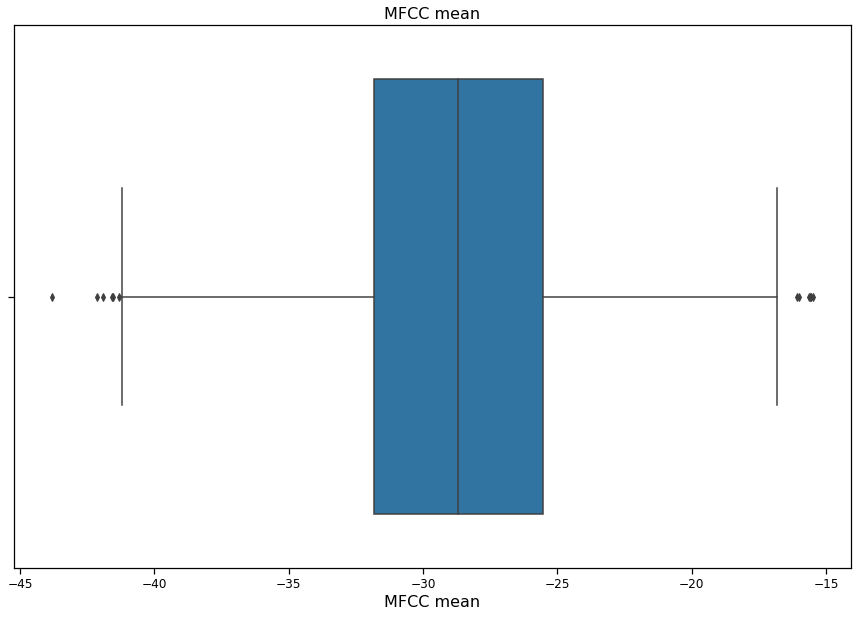

In [96]:
sns.boxplot(x = "mfcc_mean", data = df)
plt.title("MFCC mean")
plt.xlabel("MFCC mean")
#plt.savefig("boxplot_mfccMean.png")
plt.show()

In [97]:
print(outliers("mfcc_mean"))

525    -16.09
651    -41.30
823    -15.55
1380   -43.81
1392   -42.12
1479   -15.99
1480   -15.49
1563   -15.64
2025   -41.93
2300   -41.54
2319   -41.58
2404   -15.58
Name: mfcc_mean, dtype: float64


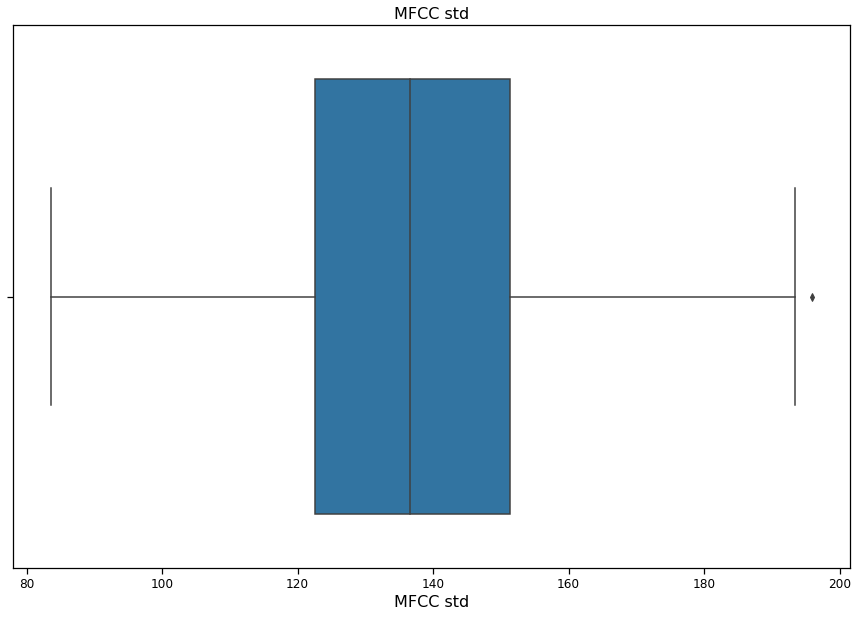

In [98]:
sns.boxplot(x = "mfcc_std", data = df)
plt.title("MFCC std")
plt.xlabel("MFCC std")
#plt.savefig("boxplot_mfccSTD.png")
plt.show()

In [99]:
print(outliers("mfcc_std"))

1380    195.94
Name: mfcc_std, dtype: float64


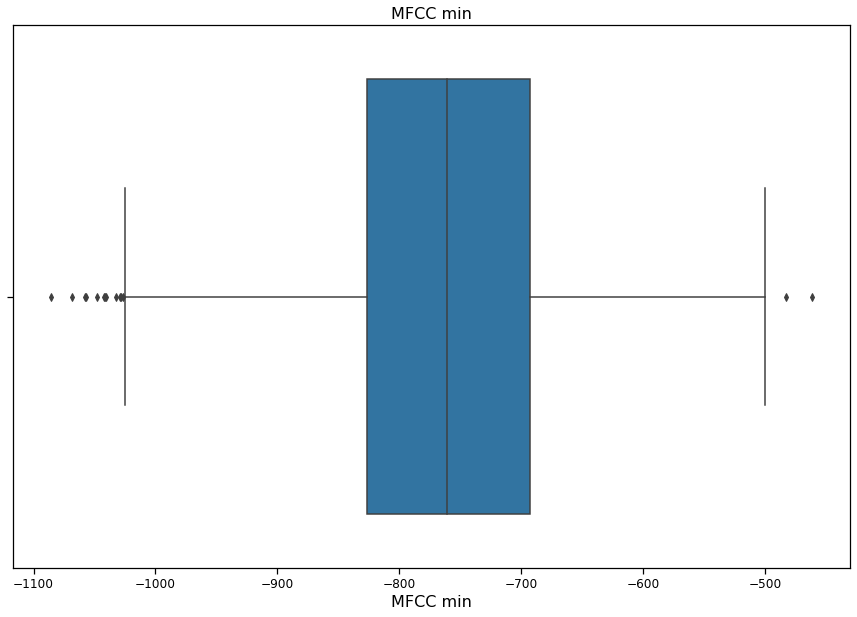

In [100]:
sns.boxplot(x = "mfcc_min", data = df)
plt.title("MFCC min")
plt.xlabel("MFCC min")
#plt.savefig("boxplot_mfccMin.png")
plt.show()

In [101]:
print(outliers("mfcc_min"))

209    -1085.48
241    -1042.14
269     -461.49
270     -482.96
349    -1057.60
651    -1041.26
748    -1032.56
1123   -1040.88
1291   -1026.95
1380   -1068.12
1829   -1047.57
2025   -1057.28
2141   -1029.37
2300   -1028.60
Name: mfcc_min, dtype: float64


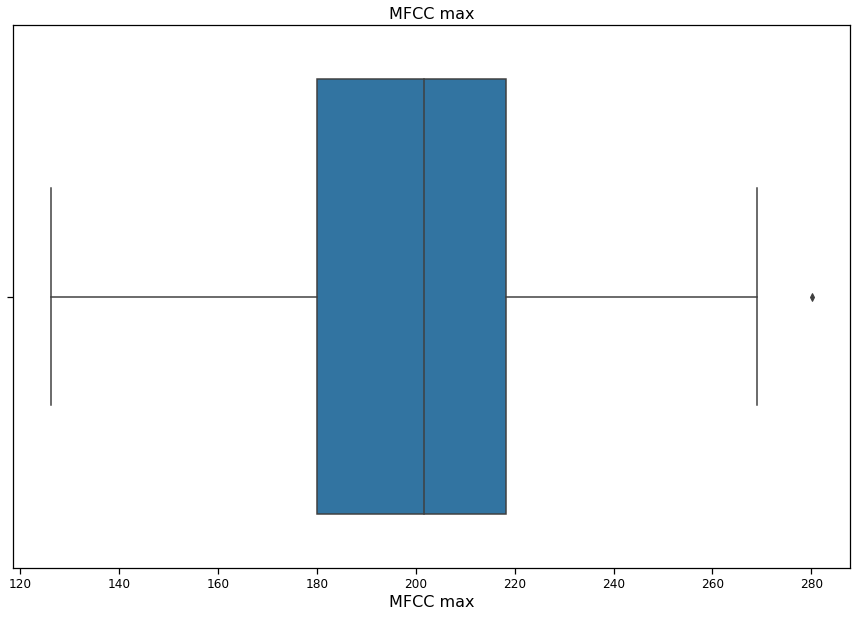

In [102]:
sns.boxplot(x = "mfcc_max", data = df)
plt.title("MFCC max")
plt.xlabel("MFCC max")
#plt.savefig("boxplot_mfccMax.png")
plt.show()

In [103]:
print(outliers("mfcc_max"))

1139    280.17
Name: mfcc_max, dtype: float64


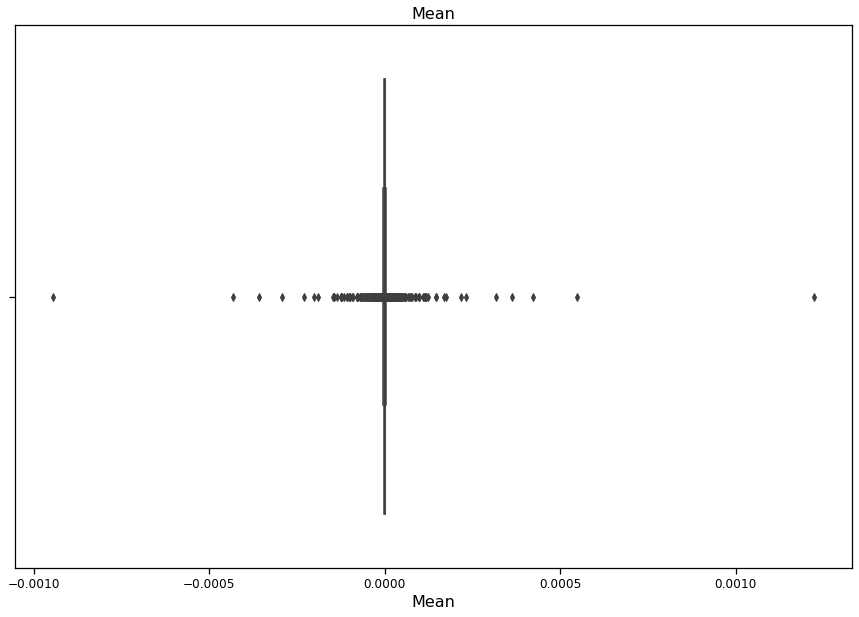

In [104]:
sns.boxplot(x = "mean", data = df)
plt.title("Mean")
plt.xlabel("Mean")
#plt.savefig("boxplot_mean.png")
plt.show()

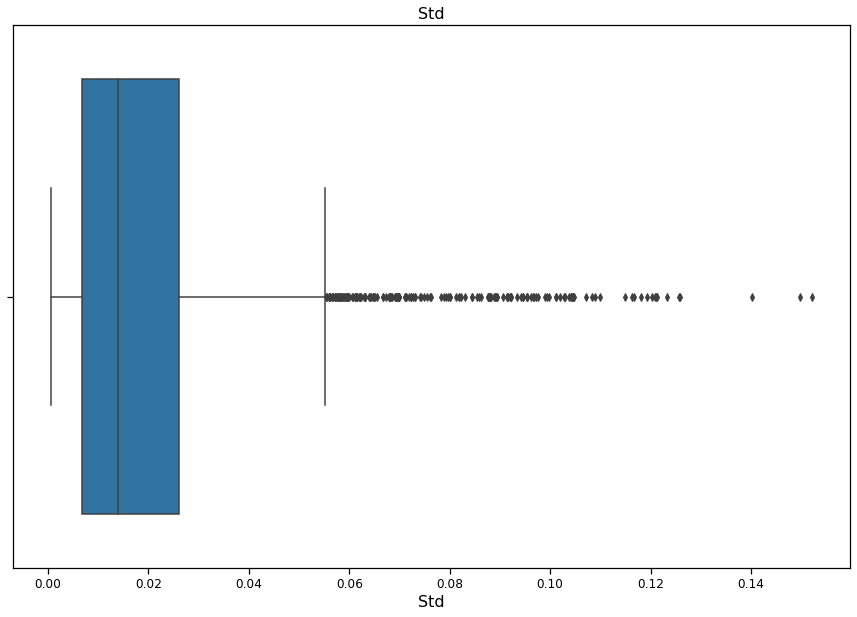

In [105]:
sns.boxplot(x = "std", data = df)
plt.title("Std")
plt.xlabel("Std")
#plt.savefig("boxplot_STD.png")
plt.show()

In [106]:
print(outliers("std"))

17      0.08
36      0.06
37      0.06
101     0.09
113     0.07
        ... 
2403    0.06
2405    0.09
2417    0.07
2423    0.12
2429    0.07
Name: std, Length: 172, dtype: float64


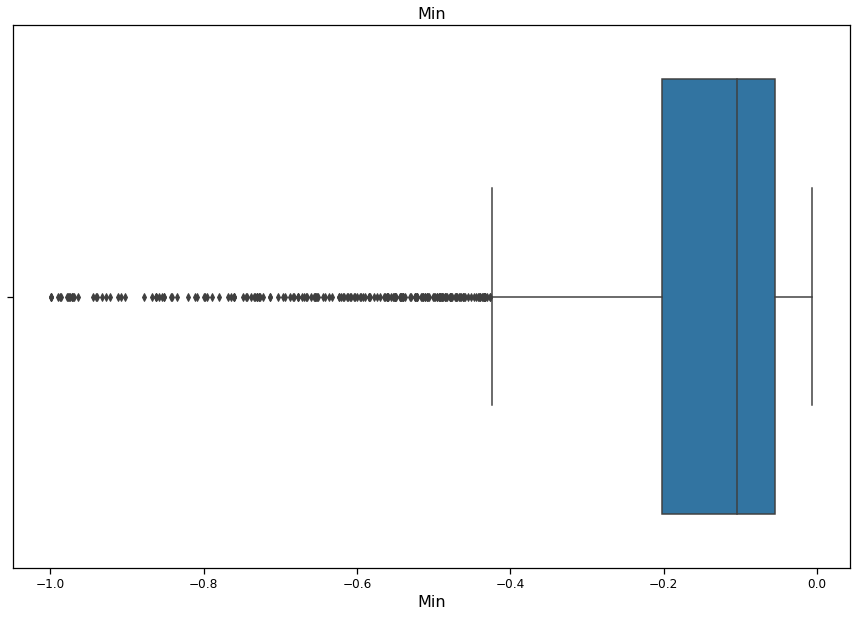

In [107]:
sns.boxplot(x = "min", data = df)
plt.title("Min")
plt.xlabel("Min")
#plt.savefig("boxplot_min.png")
plt.show()

In [108]:
print(outliers("min"))

17     -0.64
23     -0.52
33     -0.52
36     -0.52
37     -0.49
        ... 
2405   -0.68
2414   -0.47
2417   -0.76
2423   -0.98
2429   -0.67
Name: min, Length: 207, dtype: float64


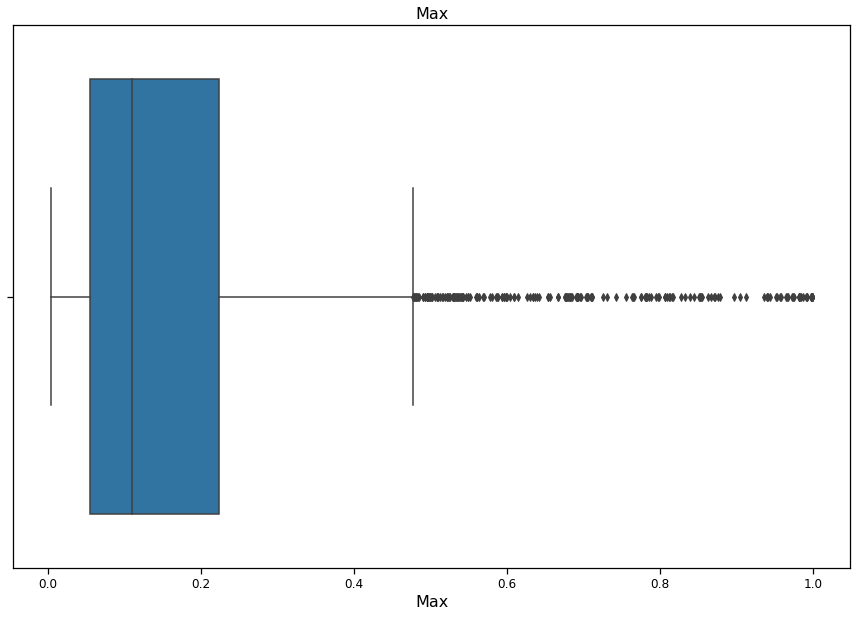

In [109]:
sns.boxplot(x = "max", data = df)
plt.title("Max")
plt.xlabel("Max")
#plt.savefig("boxplot_max.png")
plt.show()

In [110]:
print(outliers("max"))

17      0.64
23      0.49
33      0.59
36      0.54
101     1.00
        ... 
2405    0.83
2417    0.94
2423    1.00
2429    0.71
2430    0.50
Name: max, Length: 207, dtype: float64


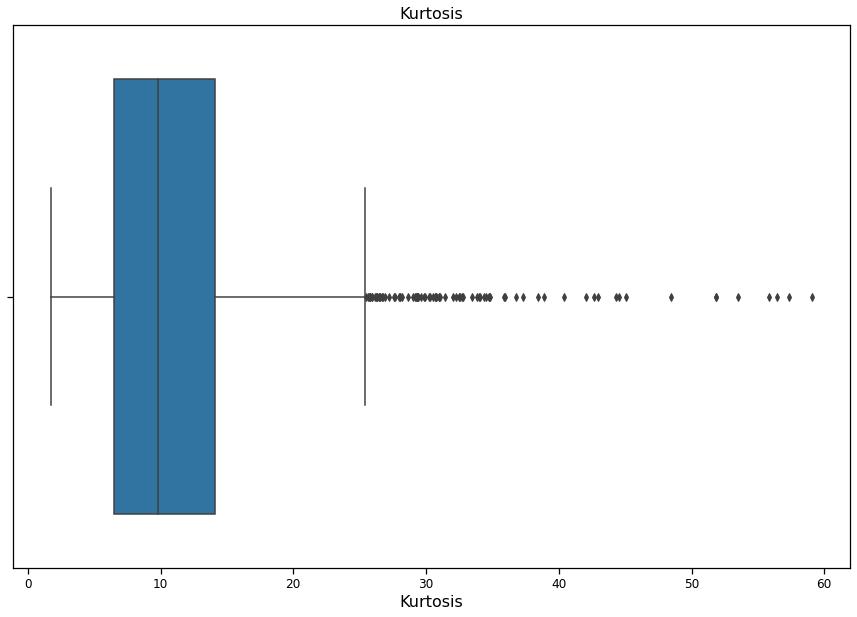

In [111]:
sns.boxplot(x = "kur", data = df)
plt.title("Kurtosis")
plt.xlabel("Kurtosis")
#plt.savefig("boxplot_kur.png")
plt.show()

In [112]:
print(outliers("kur"))

40      28.03
89      32.53
90      32.79
91      33.47
101     28.02
        ...  
2195    59.09
2289    29.90
2346    25.48
2375    29.34
2439    30.33
Name: kur, Length: 85, dtype: float64


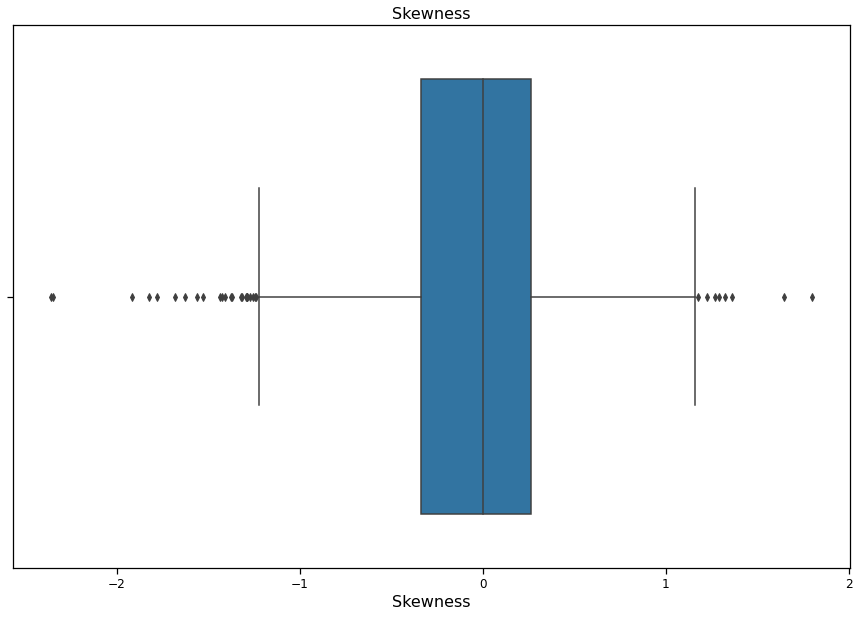

In [113]:
sns.boxplot(x = "skew", data = df)
plt.title("Skewness")
plt.xlabel("Skewness")
#plt.savefig("boxplot_skew.png")
plt.show()

In [114]:
print(outliers("skew"))

145    -1.29
153    -1.24
168    -1.42
216     1.18
433    -1.27
475     1.80
476    -1.25
508     1.22
577    -1.24
741    -1.32
758    -1.37
832    -1.32
927    -1.29
975     1.32
988     1.29
1057   -1.63
1064   -1.78
1066   -1.82
1110   -1.92
1246    1.27
1288   -1.38
1464    1.36
1522    1.64
1639   -1.29
1803   -2.35
1804   -1.53
1818   -1.41
1835   -1.56
2067   -1.43
2114   -2.36
2327   -1.29
2398   -1.68
Name: skew, dtype: float64


**Maybe at this point we can calculate outliers for categorical/nominal attributes, which are values that occurs with a frequency extremely lower than the frequency of all other values.**

# Transformation

In [115]:
df[["emotional_intensity","intensity"]]

,emotional_intensity,intensity
0,normal,-36.793432
1,normal,NaN
2,strong,-32.290737
3,normal,-49.019839
4,strong,-31.214503
...,...,...
2447,strong,NaN
2448,normal,-43.342901
2449,strong,NaN
2450,normal,-45.751265


In [116]:
df.sort_values("intensity")["intensity"].dropna()

209    -63.864613
1123   -63.864613
2025   -63.460545
2102   -62.350199
2159   -61.681723
          ...    
2345   -18.328814
1747   -18.183522
443    -17.070853
1070   -16.496218
801    -16.353953
Name: intensity, Length: 1636, dtype: float64

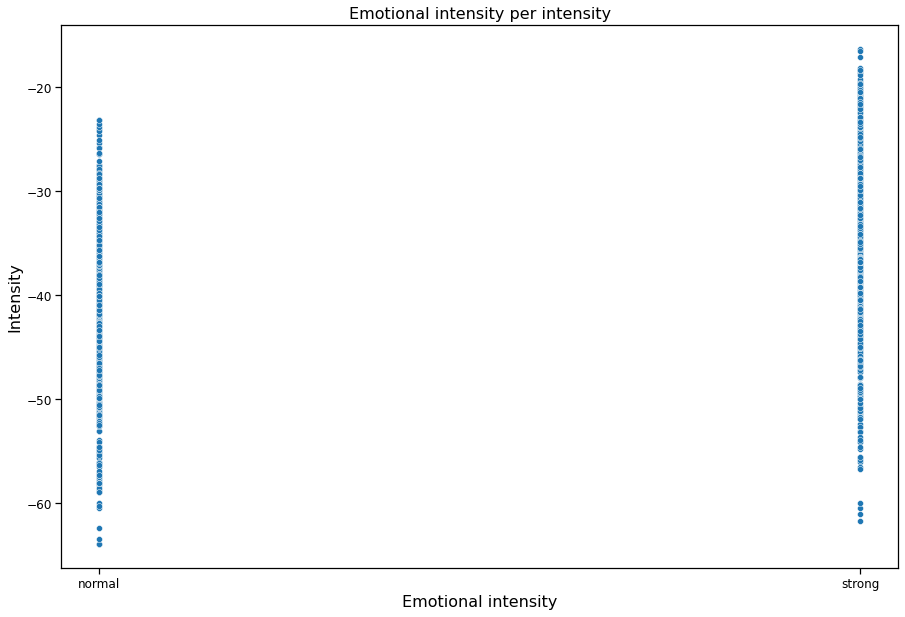

In [117]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

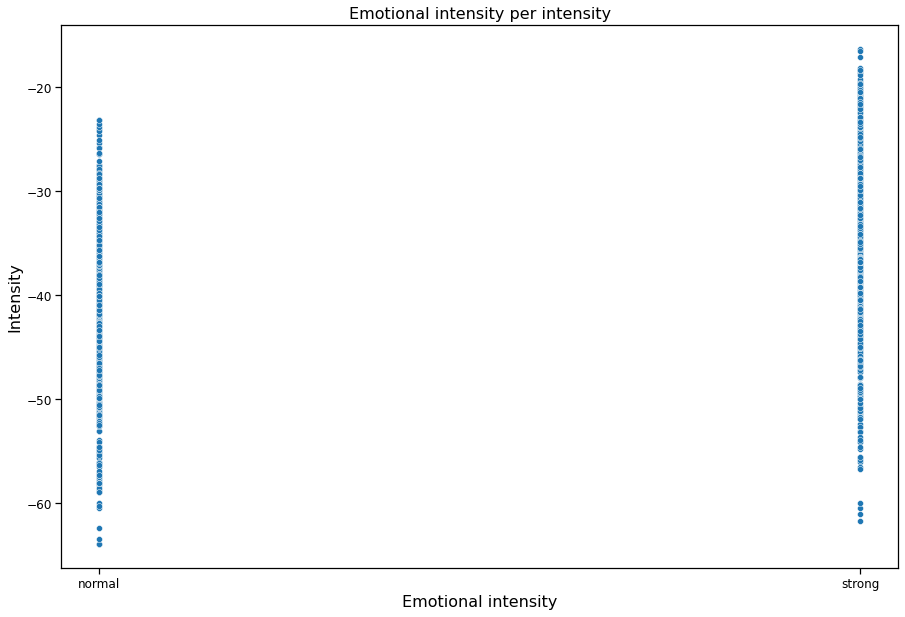

In [118]:
sns.scatterplot(x = "emotional_intensity", y = "intensity", data = df)
plt.title("Emotional intensity per intensity")
plt.xlabel("Emotional intensity")
plt.ylabel("Intensity")
#plt.savefig("boxplot_EI-intensity.png")
plt.show()

In [119]:
def densityPlot(vars):
    skew_features = df[vars]
    fig, ax = plt.subplots(1,1)
    for s in skew_features.columns:
        df[s].plot(kind = 'density')
    fig.show()

In [120]:
df['zero_crossings_rate_normalized'] = zscore(df['zero_crossings_rate'])
df = df.drop(columns=["zero_crossings_rate"])

C:\Users\claud\AppData\Local\Temp/ipykernel_13788/1420422831.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


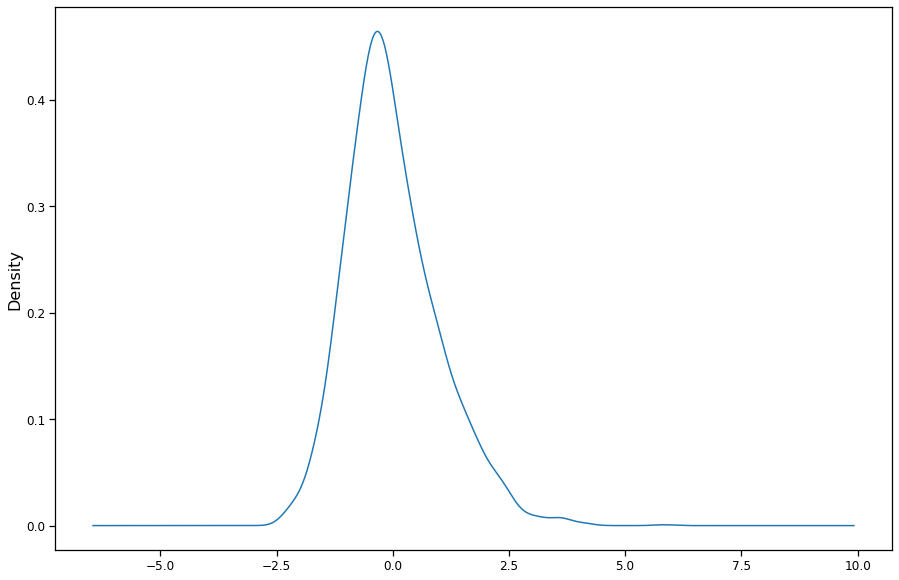

In [121]:
densityPlot(["zero_crossings_rate_normalized"])

In [122]:
df['sc_mean_normalized'] = zscore(df['sc_mean'])
df = df.drop(columns=["sc_mean"])

C:\Users\claud\AppData\Local\Temp/ipykernel_13788/1420422831.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


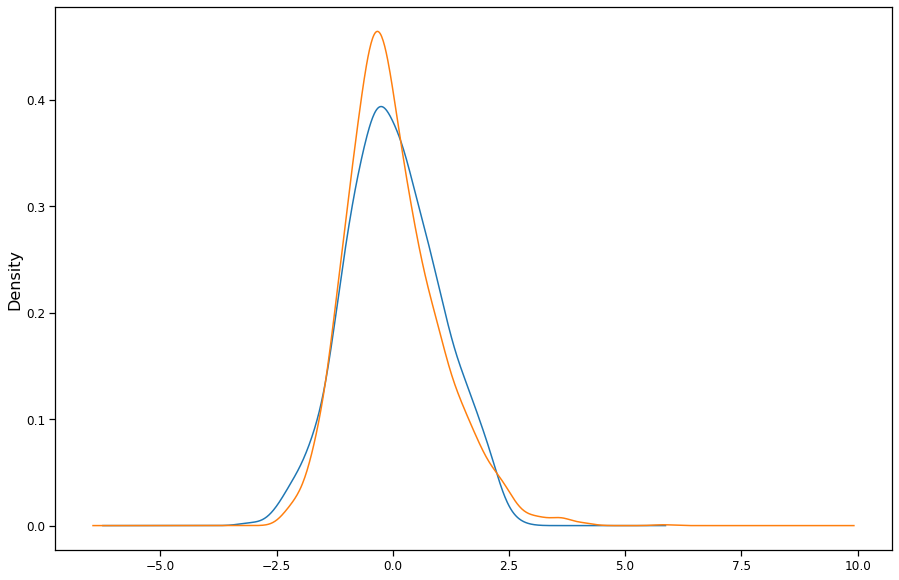

In [123]:
densityPlot(["sc_mean_normalized", "zero_crossings_rate_normalized"])

## Pairwise correlations and eventual elimination of variables

We drop _frame_rate_ column because there is just _length_ that measures the length of audio and of course _frame_rate_ is proportional to _length_.

In [124]:
df_num = df.copy() # copy of all numerical and ratio-scaled attributes

In [125]:
df_num = df_num.drop(columns = ["vocal_channel", "emotion", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "frame_width"])
df_num.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
intensity,-3.679343e+01,NaN,-32.290737,-4.901984e+01,-3.121450e+01,-3.631224e+01,NaN,-4.909504e+01,-4.590684e+01,NaN,...,-29.512788,-47.141749,NaN,NaN,-36.811776,NaN,-4.334290e+01,NaN,-45.751265,-4.001804e+01
mfcc_mean,-3.348595e+01,-2.950211e+01,-30.532463,-3.605956e+01,-3.140600e+01,-3.050089e+01,-3.017717e+01,-3.604858e+01,-3.389936e+01,-29.462296,...,-22.787794,-28.682810,-25.771196,-25.815453,-24.805220,-3.022558e+01,-3.116033e+01,-26.135280,-28.242815,-2.901924e+01
mfcc_std,1.346549e+02,1.304856e+02,126.577110,1.597252e+02,1.221258e+02,1.325817e+02,1.395075e+02,1.676521e+02,1.591976e+02,116.833786,...,113.349300,154.492430,157.241900,147.116780,138.314590,1.588455e+02,1.574997e+02,138.133210,159.943400,1.491890e+02
mfcc_min,-7.552234e+02,-7.139856e+02,-726.060360,-8.429464e+02,-7.007028e+02,-7.191655e+02,-7.671936e+02,-9.104974e+02,-8.792600e+02,-645.926200,...,-659.389100,-859.211730,-821.105700,-798.653700,-782.337340,-8.559242e+02,-8.253741e+02,-768.365360,-868.095760,-7.995101e+02
mfcc_max,1.716909e+02,2.050077e+02,165.456530,1.900361e+02,1.611340e+02,2.136819e+02,2.283271e+02,2.203837e+02,2.076322e+02,167.967530,...,202.859280,197.396960,251.228530,214.569700,219.623290,2.081850e+02,2.207949e+02,235.539380,219.843500,2.195278e+02
sc_std,3.328055e+03,4.040932e+03,3332.131300,4.053663e+03,3.442724e+03,3.833178e+03,4.008804e+03,3.737829e+03,4.014630e+03,3602.202957,...,3149.520778,3663.074145,3300.232336,3055.279038,3194.246906,4.114260e+03,4.191727e+03,4231.511986,3596.031841,3.963725e+03
sc_min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,991.364402,...,979.297084,0.000000,818.317638,511.528673,840.068705,0.000000e+00,0.000000e+00,0.000000,760.822547,0.000000e+00
sc_max,1.354196e+04,1.200029e+04,12007.751173,1.204822e+04,1.202558e+04,1.206320e+04,1.284023e+04,1.200001e+04,1.208151e+04,11999.999998,...,11981.598019,12192.374121,10834.058255,10919.537644,11191.358052,1.221052e+04,1.206456e+04,12207.179884,11981.912464,1.219977e+04
sc_kur,-1.120769e+00,-1.531204e+00,-1.130153,-1.497765e+00,-1.167544e+00,-1.114527e+00,-1.503746e+00,-1.601514e+00,-1.609622e+00,-1.288444,...,-0.083404,-0.959309,-1.540621,-1.178478,-1.478019,-1.588861e+00,-1.614582e+00,-1.337419,-1.465594,-1.501387e+00
sc_skew,2.509402e-01,2.195818e-01,0.436699,9.880228e-02,4.960657e-01,5.551978e-01,9.221132e-02,-1.127366e-01,-7.267137e-02,0.542700,...,1.129704,0.506089,-0.184184,0.421965,0.424980,1.843897e-01,-1.139205e-01,0.619346,0.206481,1.475739e-01


In [126]:
#sns.pairplot(df_num)
#plt.savefig("pairplot_df_num.png")
#plt.show()

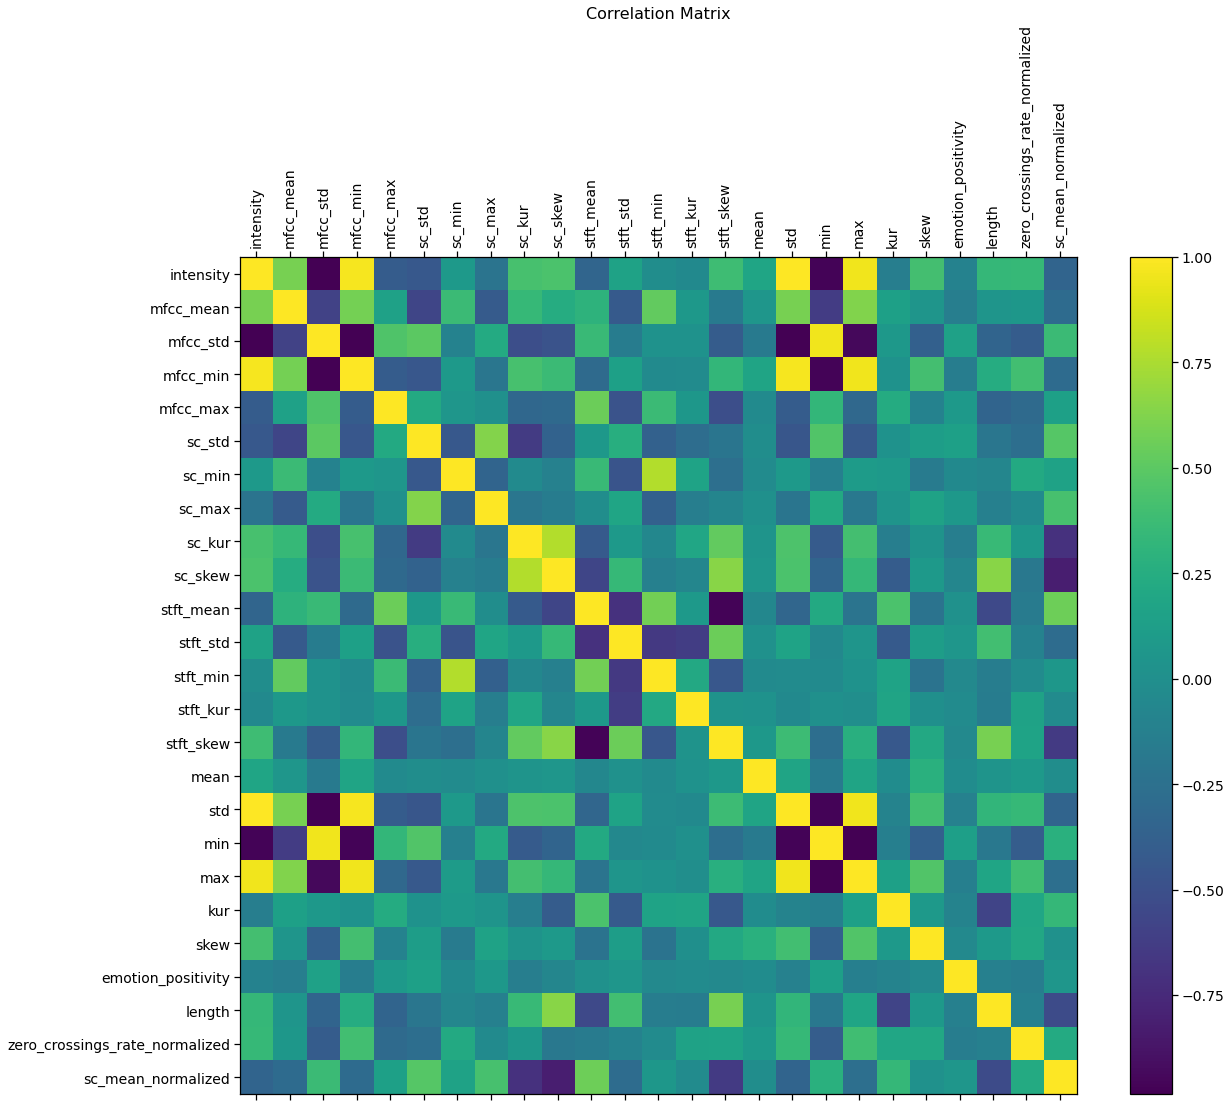

In [127]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_num.corr("spearman"), fignum=f.number)
plt.xticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [128]:
corr = df_num[["intensity", "mfcc_min", "min"]].corr("spearman")
corr.style.background_gradient(cmap='coolwarm')

,intensity,mfcc_min,min
intensity,1.000000,0.972007,-0.961140
mfcc_min,0.972007,1.000000,-0.968147
min,-0.961140,-0.968147,1.000000


In [129]:
eps = 0.90
print("CORRELATION > ",eps,":")
corr = (df_num.corr())
for index, row in corr.iterrows():
    for k, v in row.items():
        if(v > eps and index != k):
            print(index, k, corr[index][k])
    
print("")
print("CORRELATION < -",eps,":")
neg_corr = (df_num.corr())
for index, row in neg_corr.iterrows():
    for k, v in row.items():
        if(v  < -eps and index != k):
            print(index, k, v)

CORRELATION >  0.9 :
intensity mfcc_min 0.9739806185030634
mfcc_min intensity 0.9739806185030634
std max 0.9528208795190594
max std 0.9528208795190594

CORRELATION < - 0.9 :
intensity mfcc_std -0.9787440246139893
mfcc_std intensity -0.9787440246139893
mfcc_std mfcc_min -0.9760982975983237
mfcc_min mfcc_std -0.9760982975983237
stft_mean stft_skew -0.9699787898983478
stft_skew stft_mean -0.9699787898983478
std min -0.9558475650435299
min std -0.9558475650435299
min max -0.9798894359969872
max min -0.9798894359969872


In [130]:
df_num = df_num.drop(columns=["mfcc_min", "max", "mfcc_std", "stft_skew", "min"])

In [131]:
df_num.describe()

,intensity,mfcc_mean,mfcc_max,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,mean,std,kur,skew,emotion_positivity,length,zero_crossings_rate_normalized,sc_mean_normalized
count,1636.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2.452000e+03,2.452000e+03
mean,-37.625332,-28.769180,199.182514,3365.453393,551.834124,11830.461864,-1.142642,0.348442,0.475846,0.331371,0.002272,-1.247929,1.393649e-08,0.020504,11.203002,-0.048245,-0.306688,4.092151,-4.746973e-16,5.922397e-16
std,8.451982,4.461886,26.002107,580.479034,508.025890,1004.955976,0.572654,0.353005,0.082551,0.023773,0.004830,0.211781,4.267587e-05,0.021024,6.614859,0.454925,0.822315,0.598322,1.000204e+00,1.000204e+00
min,-63.864613,-43.812923,126.250810,1491.341071,0.000000,7657.495158,-1.795576,-0.510390,0.214089,0.210126,0.000000,-1.669603,-9.435575e-04,0.000652,1.757794,-2.356526,-1.000000,2.936000,-2.357317e+00,-3.210512e+00
25%,-43.539869,-31.828597,180.081417,3025.431971,0.000000,11516.034429,-1.496187,0.098549,0.415260,0.317780,0.000000,-1.390612,-1.394488e-06,0.006791,6.519988,-0.336624,-1.000000,3.604000,-6.757194e-01,-6.930420e-01
50%,-37.072745,-28.681109,201.697175,3433.835368,707.319256,12000.292653,-1.308938,0.347621,0.475740,0.334224,0.000190,-1.292105,-9.810701e-08,0.013880,9.828686,0.004256,-1.000000,4.004000,-1.498243e-01,-5.415859e-02
75%,-31.591309,-25.550238,218.185288,3768.503344,977.693852,12091.886054,-0.982944,0.557427,0.530571,0.349272,0.001999,-1.152519,8.363511e-07,0.026154,14.085435,0.262978,0.000000,4.538000,5.626651e-01,6.924041e-01
max,-16.353953,-15.491450,280.173700,4819.783069,2121.417965,17477.540047,3.657953,1.825436,0.724077,0.391928,0.039378,0.794669,1.222810e-03,0.152168,59.085695,1.799676,1.000000,6.373000,5.826633e+00,2.840245e+00


In [132]:
desc = df_num.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

intensity: 11.948559652602661
mfcc_mean: 6.278359000000002
mfcc_max: 38.10387000000003
sc_std: 743.0713734869682
sc_min: 977.6938519007109
sc_max: 575.8516251850451
sc_kur: 0.513242853914685
sc_skew: 0.45887848473075143
stft_mean: 0.115310735
stft_std: 0.03149214
stft_min: 0.0019994863500000003
stft_kur: 0.23809270305753993
mean: 2.230838875e-06
std: 0.019363594499999998
kur: 7.56544712292974
skew: 0.5996017074669128
emotion_positivity: 1.0
length: 0.9340000000000002
zero_crossings_rate_normalized: 1.2383845166095826
sc_mean_normalized: 1.385446152388487


Treshold > 15: "mfcc_max", "sc_std", "sc_min", "sc_max"

In [133]:

df_num["intensity_normalized"] = zscore(df_num["intensity"].dropna())
df_num["mfcc_mean_normalized"] = zscore(df_num["mfcc_mean"])
df_num["mfcc_max_normalized"] = zscore(df_num["mfcc_max"])
df_num["sc_std_normalized"] = zscore(df_num["sc_std"])
df_num["sc_min_normalized"] = zscore(df_num["sc_min"])
df_num["sc_max_normalized"] = zscore(df_num["sc_max"])
df_num["stft_min_normalized"] = zscore(df_num["stft_min"])
df_num["mean_normalized"] = zscore(df_num["mean"])
df_num["std_normalized"] = zscore(df_num["std"])
df_num["kur_normalized"] = zscore(df_num["kur"])
df_num = df_num.drop(columns=["intensity", "mfcc_mean", "sc_std", "mfcc_max", "sc_std", "sc_min", "sc_max", "stft_min", "mean", "std", "kur"])

In [134]:
desc = df_num.describe()
for v in desc:
    print(v + ": "  + str(desc[v]["75%"] - desc[v]["25%"]))

sc_kur: 0.513242853914685
sc_skew: 0.45887848473075143
stft_mean: 0.115310735
stft_std: 0.03149214
stft_kur: 0.23809270305753993
skew: 0.5996017074669128
emotion_positivity: 1.0
length: 0.9340000000000002
zero_crossings_rate_normalized: 1.2383845166095826
sc_mean_normalized: 1.385446152388487
intensity_normalized: 1.4141314054531322
mfcc_mean_normalized: 1.4073958144370113
mfcc_max_normalized: 1.4657136147189087
sc_std_normalized: 1.2803613910025171
sc_min_normalized: 1.9248886677577186
sc_max_normalized: 0.5731286741893198
stft_min_normalized: 0.41407111589780127
mean_normalized: 0.052284674357053265
std_normalized: 0.9212157954765399
kur_normalized: 1.1439381927818992


In [135]:
df_num.T

,0,1,2,3,4,5,6,7,8,9,...,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451
sc_kur,-1.120769,-1.531204,-1.130153,-1.497765,-1.167544,-1.114527,-1.503746,-1.601514,-1.609622,-1.288444,...,-0.083404,-0.959309,-1.540621,-1.178478,-1.478019,-1.588861,-1.614582,-1.337419,-1.465594,-1.501387
sc_skew,0.250940,0.219582,0.436699,0.098802,0.496066,0.555198,0.092211,-0.112737,-0.072671,0.542700,...,1.129704,0.506089,-0.184184,0.421965,0.424980,0.184390,-0.113920,0.619346,0.206481,0.147574
stft_mean,0.415250,0.417488,0.379758,0.407277,0.415974,0.349669,0.476312,0.487306,0.535030,0.506043,...,0.434530,0.493316,0.647158,0.575689,0.466211,0.573838,0.591010,0.467994,0.578854,0.554946
stft_std,0.335533,0.352380,0.352270,0.360552,0.350655,0.345256,0.346839,0.328248,0.328253,0.367643,...,0.337443,0.323536,0.280072,0.315758,0.340911,0.304496,0.306333,0.347843,0.308684,0.320787
stft_kur,-1.215025,-1.384174,-1.242947,-1.445318,-1.366742,-1.098179,-1.425898,-1.307958,-1.262960,-1.544716,...,-1.323040,-1.183935,-0.894654,-1.256183,-1.426536,-1.075888,-1.026071,-1.473789,-1.277117,-1.257666
skew,0.273153,0.292157,0.302659,-0.081014,0.414872,0.028186,0.011188,0.211353,-0.964433,0.475098,...,-0.002707,-0.520648,-0.021519,0.226566,0.227780,0.759247,1.073633,-0.005821,-0.110966,1.032081
emotion_positivity,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,...,-1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
length,3.737000,3.904000,4.671000,3.637000,4.404000,3.570000,3.770000,3.437000,3.770000,4.371000,...,4.872000,3.837000,3.504000,3.237000,5.005000,4.605000,4.171000,5.239000,3.737000,3.837000
zero_crossings_rate_normalized,1.620277,0.462944,0.986986,0.031052,0.316326,0.274410,0.715285,0.088720,1.043515,-0.220751,...,-1.057849,-0.543516,-1.255952,-0.897927,-0.439393,-1.202356,-1.196080,-1.530655,-0.666520,-0.834500
sc_mean_normalized,0.711365,0.031450,-0.387835,0.235821,-0.027530,-1.050260,0.626448,1.045826,1.347705,0.361831,...,-1.430158,-0.583105,0.496742,-0.599125,-0.915396,0.818903,1.637291,-0.589647,0.405295,1.042934


## Analysis by centroid-based methods

### KMeans

**KMeans function**

In [136]:
#def kmeans (variables, clusters) :
#    global hier
#    global kmeans
#    global scaler
#    X = variables.values
#    scaler = MinMaxScaler()
#    X_minmax = scaler.fit_transform(X)
#    dist = pdist(X_minmax, 'euclidean')
#    dist = squareform(dist)
#    hier = AgglomerativeClustering(n_clusters = clusters, affinity = 'precomputed', linkage = 'complete')
#    hier.fit(dist)
#    kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)
#    kmeans.fit(X_minmax)

**SSE plot function**

In [137]:
def drawSSEPlot(df, column_indices, xlabel, ylabel, n_clusters = 8, max_iter = 300, tol = 1e-04, init = 'k-means++', n_init = 10, algorithm = 'auto'):
    inertia_values = []
    for i in range(1, n_clusters + 1):
        km = KMeans(n_clusters = i, max_iter = max_iter, tol = tol, init = init, n_init = n_init, random_state = 1, algorithm = algorithm)
        km.fit_predict(df.iloc[:, column_indices])
        inertia_values.append(km.inertia_)
    fig, ax = plt.subplots(figsize = (8, 6))
    plt.plot(range(1, n_clusters + 1), inertia_values, color = 'red')
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(xlabel + ' vs ' + ylabel, fontsize = 15)
    plt.grid()
    plt.show()

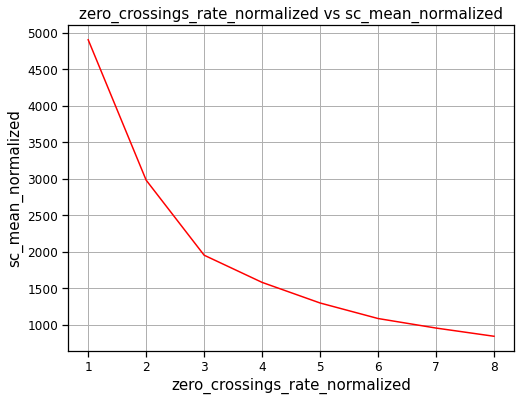

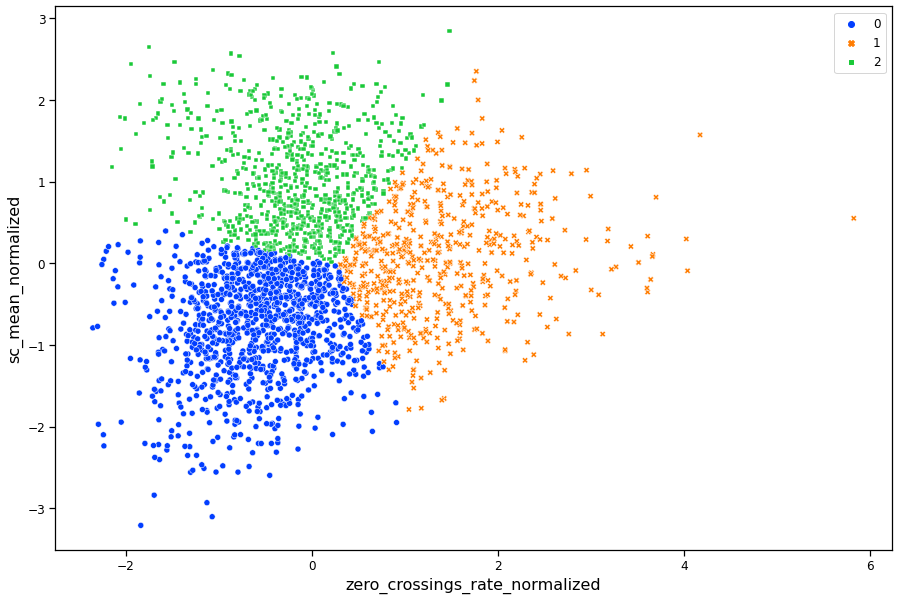

In [143]:
xvar = "zero_crossings_rate_normalized"
yvar = "sc_mean_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [8, 9], xvar, yvar)
kmeans = KMeans(n_clusters = 3, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

According to the graph, three clusters are a good compromise between complexity and efficiency because the trend of the SSE becomes more linear with three clusters. The shape is more or less globular.

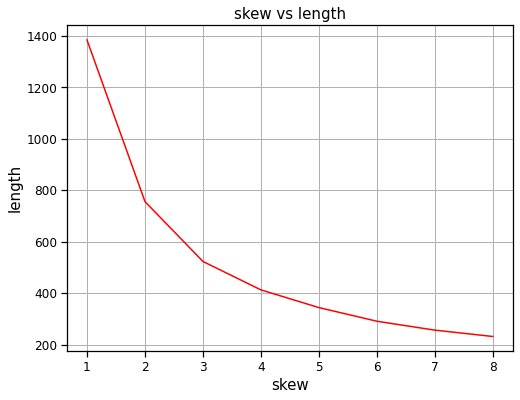

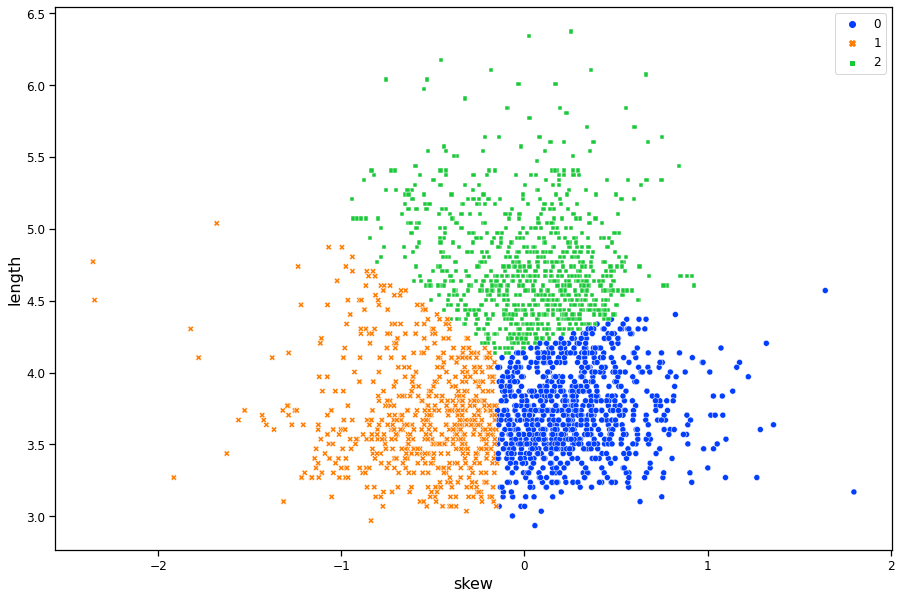

In [146]:
xvar = "skew"
yvar = "length"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [5, 7], xvar, yvar)
kmeans = KMeans(n_clusters = 3, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

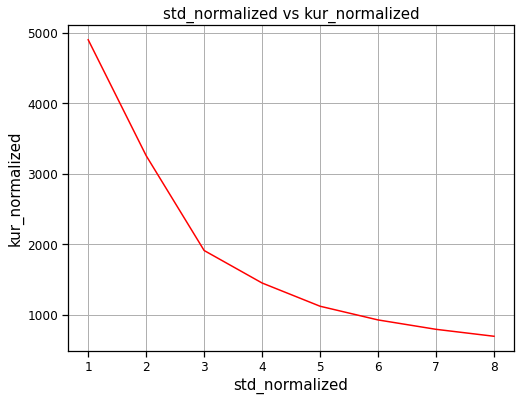

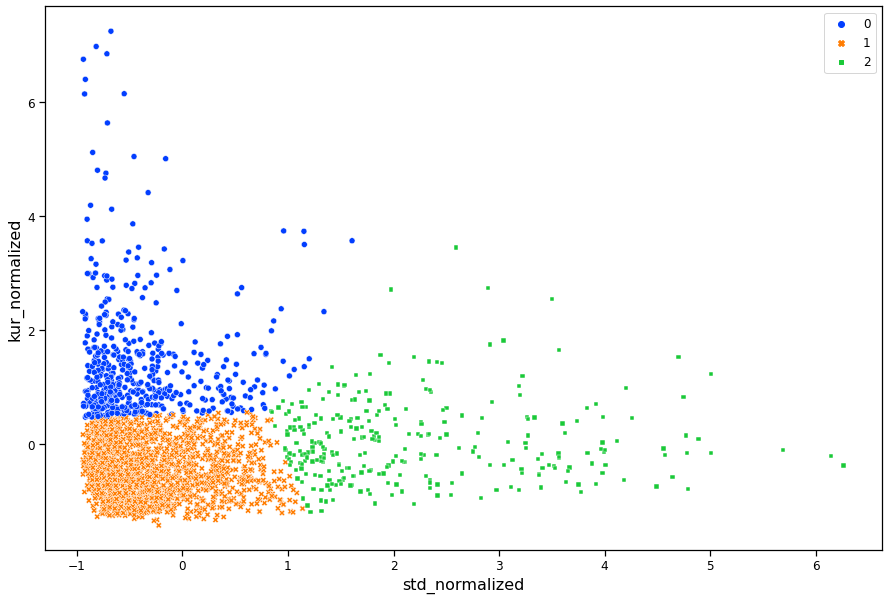

In [150]:
xvar = "std_normalized"
yvar = "kur_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [18, 19], xvar, yvar)
kmeans = KMeans(n_clusters = 3, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

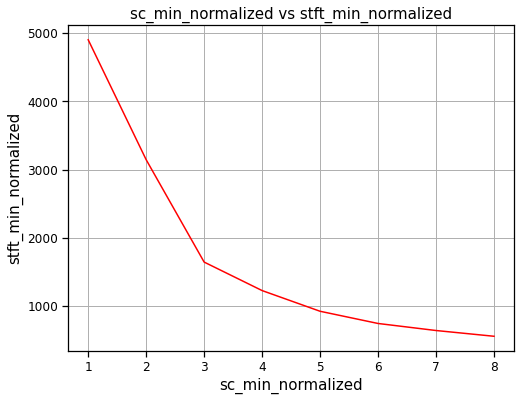

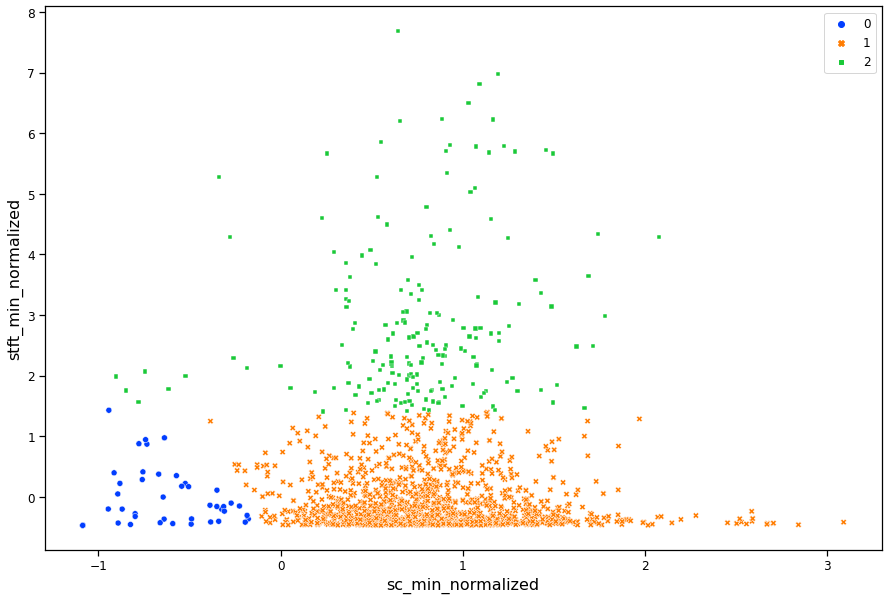

In [149]:
xvar = "sc_min_normalized"
yvar = "stft_min_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [13, 16], xvar, yvar)
kmeans = KMeans(n_clusters = 3, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

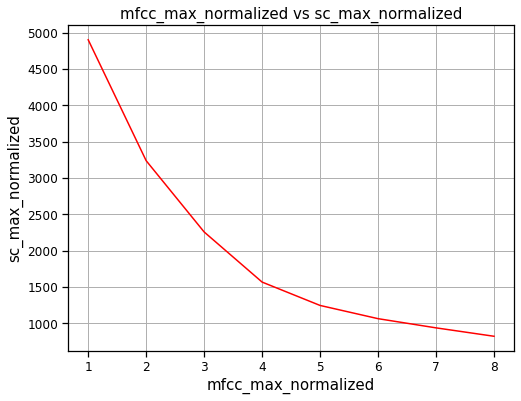

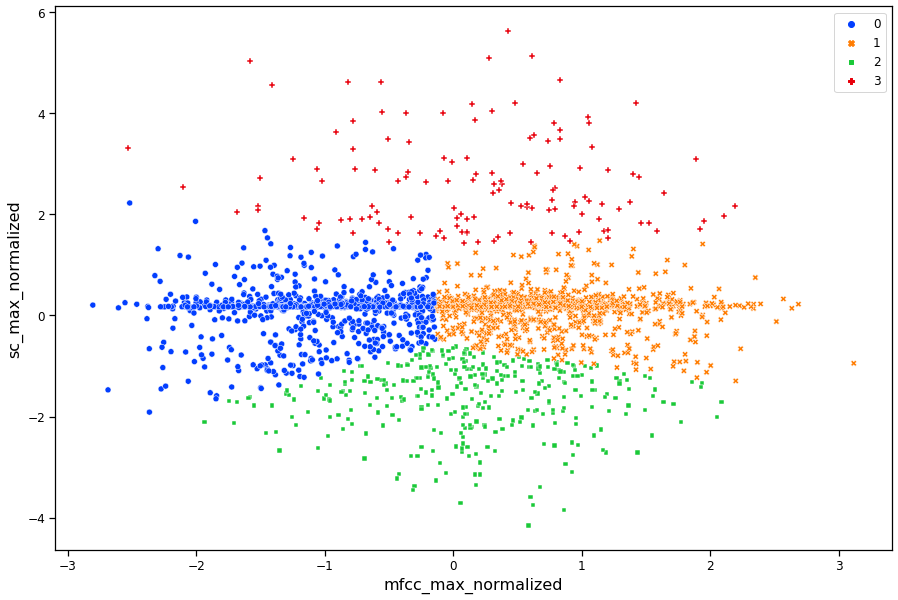

In [151]:
xvar = "mfcc_max_normalized"
yvar = "sc_max_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [12, 15], xvar, yvar)
kmeans = KMeans(n_clusters = 4, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

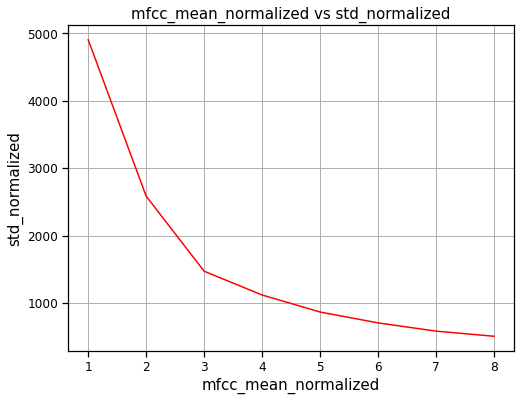

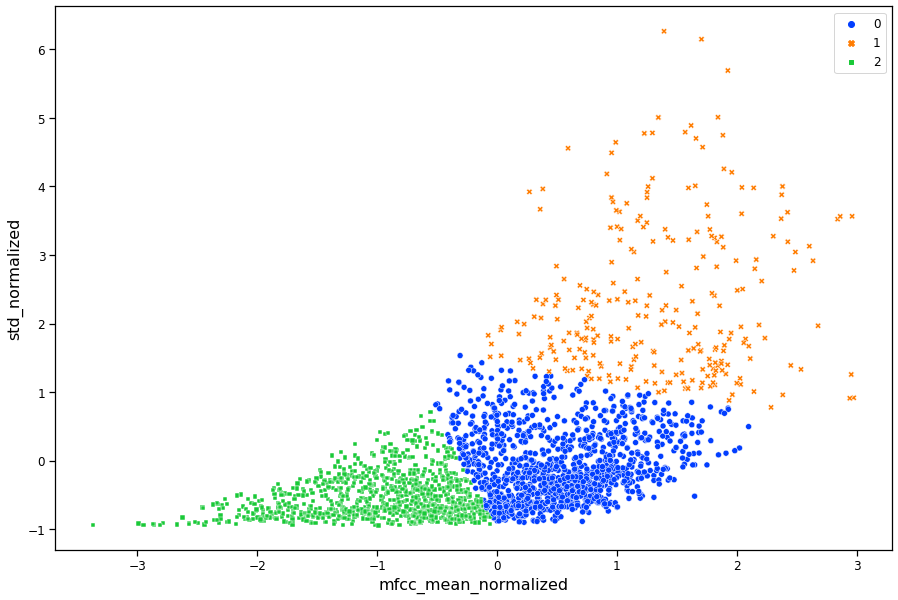

In [152]:
xvar = "mfcc_mean_normalized"
yvar = "std_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [11, 18], xvar, yvar)
kmeans = KMeans(n_clusters = 3, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()

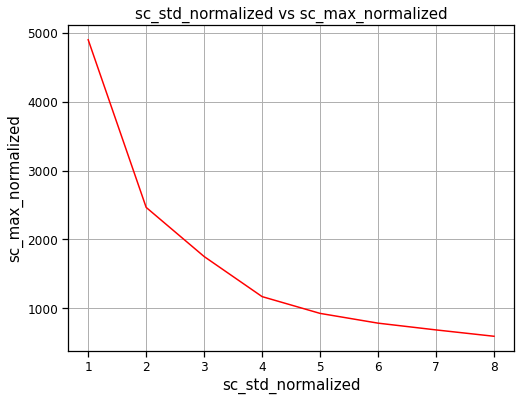

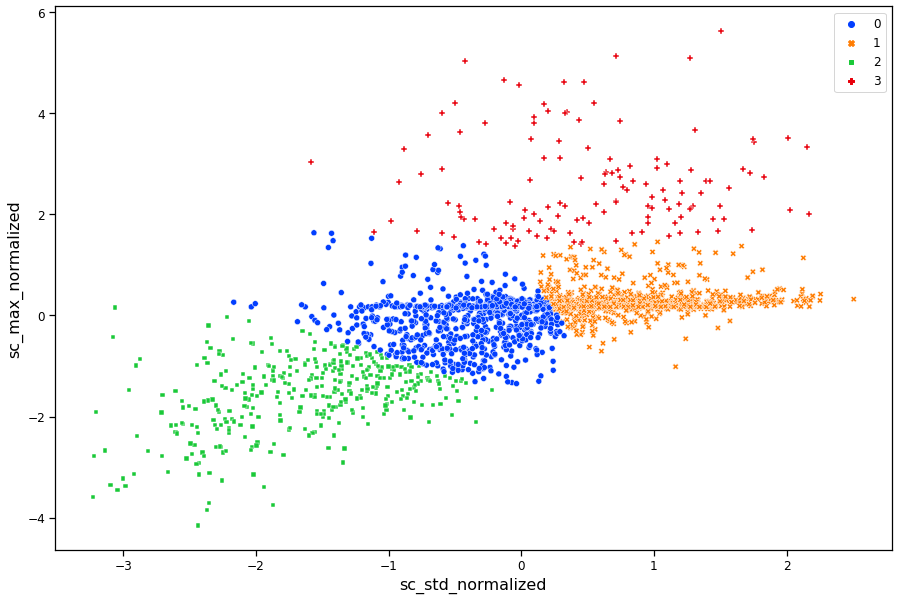

In [153]:
xvar = "sc_std_normalized"
yvar = "sc_max_normalized"
X = df_num[[xvar, yvar]].values
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)
drawSSEPlot(df_num, [13, 15], xvar, yvar)
kmeans = KMeans(n_clusters = 4, n_init = 10, max_iter = 100)
kmeans.fit(X_scal)
#centers = kmeans.cluster_centers_
#centers = scaler.inverse_transform(centers)
#df['kmeans_labels'] = kmeans.labels_
#df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})
sns.scatterplot(data = df_num, x = xvar, y = yvar, hue = kmeans.labels_, style = kmeans.labels_,
                palette = "bright")
plt.legend()
plt.show()